In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table, join
import illustris_python as il
from astropy.table import setdiff
import time as time
import scipy.signal as signal
import scipy.interpolate as interpolate
from astropy.cosmology import Planck15 as cosmo
from astropy.table import vstack
import h5py
import matplotlib.gridspec as gridspec

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))


# Notebook Loading

In [4]:
"""
300-1 Loading
"""
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-300-1/output'
snapshot_ind = 66


"""
100-3 Loading
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-100-3/ouput'
snapshot_ind = 66
"""

#Header gives basic group info
header = il.groupcat.loadHeader(basePath, snapshot_ind)
scale_factor = header['Time']

#Relevant fields
fields = ['SubhaloFlag','SubhaloGrNr', 'SubhaloMass', 'SubhaloMassType', 'SubhaloPos','SubhaloSFR',
          'SubhaloSpin','SubhaloStarMetallicity','SubhaloStellarPhotometrics','SubhaloVel','SubhaloVmax', 'SubhaloBHMass','SubhaloStarMetalFractions']
fields2 = ['GroupFirstSub', 'GroupMass', 'GroupMassType','GroupNsubs','GroupPos','GroupVel',
           'Group_M_Mean200','Group_M_Crit200','Group_M_Crit500','Group_R_Crit200','Group_R_Crit500','Group_R_Mean200']
#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind, fields = fields)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields = fields2)

'''
#Fields for Profiles - QuickLoad
fields_prof = ['SubhaloFlag','SubhaloGrNr', 'SubhaloMass', 'SubhaloMassType', 'SubhaloPos']
fields_prof2 =['GroupFirstSub', 'GroupMass', 'GroupMassType','GroupNsubs','Group_M_Mean200','Group_M_Crit200','Group_M_Crit500','Group_R_Crit200','Group_R_Crit500','Group_R_Mean200']
#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind, fields = fields_prof)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields = fields_prof2)'''


#Get the keys for each
subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

print(subhalo_grp['count'])
print(halo_grp['count'])
halo_grp.pop('count')
halo_keys.remove('count')
subhalo_grp.pop('count')
subhalo_keys.remove('count')

subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))
subhalo_table = Table(list(subhalo_grp.values()), names=(subhalo_keys))
subhalo_table.add_column([x for x in range(len(subhalo_table))], name='Index' ,index=0)

del subhalo_grp

halo_table = Table(list(halo_grp.values()), names=(halo_keys))
halo_table.add_column([x for x in range(len(halo_table))], name='SubhaloGrNr' ,index=0)

subhalo_table = join(subhalo_table, halo_table, keys='SubhaloGrNr', join_type='left')

subhalo_table.add_column(subhalo_table["SubhaloMassType"][:,4], name=str("StellarMass"))
subhalo_table.add_column(subhalo_table['GroupFirstSub'] == subhalo_table['Index'],name=str("IsCentral"))

15904796
18767465


In [5]:
#del halo_table

In [6]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass < num
        return table[mask]

## Main Cuts 

In [12]:
subhalo_table = subhalo_table[subhalo_table['SubhaloFlag']]
subhalo_table = subhalo_table[subhalo_table['SubhaloMassType'][:,4]!=0]
subhalo_table = cut_mass_high(subhalo_table, "SubhaloMassType", 9)

print(len(subhalo_table))

#Halo Selection
selected_subhalos = cut_mass_high(subhalo_table, "Group_M_Mean200", 13.8)
#print(np.min(np.array(np.log10(selected_subhalos["GroupMass"]*1e10))))
print(len(selected_subhalos))

addable = cut_mass_low(subhalo_table, "Group_M_Mean200", 13.8)
'''
halo_table_1 = cut_mass_high(halo_table, "Group_M_Mean200", 13.7)
np.save("Table_Group_M_Mean200_5e13", halo_table_1['SubhaloGrNr'])

halo_table_2 = cut_mass_high(halo_table, "Group_M_Mean200", 13.8)
np.save("Table_Group_M_Mean200_13.8", halo_table_2['SubhaloGrNr'])

halo_table_3 = cut_mass_high(halo_table, "Group_M_Mean200", 14)
np.save("Table_Group_M_Mean200_14", halo_table_3['SubhaloGrNr'])
'''

232118
12569


'\nhalo_table_1 = cut_mass_high(halo_table, "Group_M_Mean200", 13.7)\nnp.save("Table_Group_M_Mean200_5e13", halo_table_1[\'SubhaloGrNr\'])\n\nhalo_table_2 = cut_mass_high(halo_table, "Group_M_Mean200", 13.8)\nnp.save("Table_Group_M_Mean200_13.8", halo_table_2[\'SubhaloGrNr\'])\n\nhalo_table_3 = cut_mass_high(halo_table, "Group_M_Mean200", 14)\nnp.save("Table_Group_M_Mean200_14", halo_table_3[\'SubhaloGrNr\'])\n'

In [7]:
boxsize = header['BoxSize'] #kpc/h
print(len(subhalo_table))
Nsubs = len(subhalo_table)
rho_g = Nsubs/(boxsize*.001)**3
print('rho_g=',rho_g)

Nsubs_b = len((subhalo_table)[((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) < 0.5)])
rho_g_b = Nsubs_b/(boxsize*.001)**3
print('rho_g_b=',rho_g_b)
Nsubs_r = len((subhalo_table)[(np.log10(subhalo_table['StellarMass']*1e10)>=10.2) & ((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) > 0.55)])
rho_g_r = Nsubs_r/(boxsize*.001)**3
print('rho_g_r=',rho_g_r)
Nsubs_g = len((subhalo_table)[(np.log10(subhalo_table['StellarMass']*1e10)<10.2) & ((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) > 0.55)])
rho_g_g = Nsubs_g/(boxsize*.001)**3
print('rho_g_g=',rho_g_g)
rho_g_list = [rho_g,rho_g_b, rho_g_r, rho_g_g]


Nsubs_b1 = len((subhalo_table)[((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) < 0.25)])
rho_g_b1 = Nsubs_b1/(boxsize*.001)**3
print('rho_g_b1=',rho_g_b1)
Nsubs_b2 = len((subhalo_table)[((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) >= 0.25) & ((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) < 0.55)])
rho_g_b2 = Nsubs_b2/(boxsize*.001)**3
print('rho_g_b2=',rho_g_b2)
rho_g_listB = [rho_g, rho_g_b1, rho_g_b2]

15904796
rho_g= 1.846148024549847
rho_g_b= 1.7958930369553547


<ipython-input-7-bea20c984338>:10: RuntimeWarning: divide by zero encountered in log10
  Nsubs_r = len((subhalo_table)[(np.log10(subhalo_table['StellarMass']*1e10)>=10.2) & ((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) > 0.55)])


rho_g_r= 0.002960374922012159


<ipython-input-7-bea20c984338>:13: RuntimeWarning: divide by zero encountered in log10
  Nsubs_g = len((subhalo_table)[(np.log10(subhalo_table['StellarMass']*1e10)<10.2) & ((subhalo_table['SubhaloStellarPhotometrics'][:,4]-subhalo_table['SubhaloStellarPhotometrics'][:,5]) > 0.55)])


rho_g_g= 0.01831650730546568
rho_g_b1= 1.6201503750671058
rho_g_b2= 0.20472076725526328


In [10]:
np.save("rho_list_"+str(snapshot_ind), rho_g_list)
np.save("rho_listb_"+str(snapshot_ind), rho_g_listB)

In [13]:
centrals = selected_subhalos[selected_subhalos['IsCentral']]
centrals = centrals[centrals['GroupNsubs']>=1]
print(len(centrals))
'''
field_galaxies = subhalo_table[subhalo_table['GroupNsubs']<=2]
field_galaxies = field_galaxies
print(len(field_galaxies))
del subhalo_table
'''
satellites = selected_subhalos[np.bitwise_not(selected_subhalos['IsCentral'])]
print(len(satellites))
satellites_red = cut_mass_high(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, 0, 0.5)
print("Satellite galaxies red1: " + str(len(satellites_red)))
print("Satellite galaxies red2: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))
print(len(satellites_red)+len(satellites_green)+len(satellites_blue))


198
12371
Satellite galaxies red1: 2577
Satellite galaxies red2: 6342
Satellite galaxies blue: 2877
11796


In [9]:
og_sats_green = satellites_green.copy()
print(len(og_sats_green))

6342


## Adding Galaxies 

In [13]:
'''
New Method of adding galaxies to their respective halos. 

Return to the old method of splitting into field, centrals, satellites, but only select new satellites
out of field galaxies. Then, simply add them into the list of satellite galaxies and overwrite their halo
properties with those of the new halo, then recalculate the overall halo mass, and cut more strictly on that.

Code gives nearly the same results when order through which galaxies are iterated is switched - 
this is good to see.

DEPRECATE ABOVE, IT DOESNT WORK
'''

t0 = time.time()

#iterate through all central galaxies
for i in range(0, len(centrals)):
    
    #get center of mass location for current central
    gal_cm = centrals['SubhaloPos'][i]
    
    #radius in Mpc/h to cut at
    value =  centrals['Group_R_Mean200'][i]*6*scale_factor*0.001
    
    #Get basic info about the box bounds to prevent wrapping issues.
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)

    #Create an array of distances from all subhalos in the data satisfying a certain criterion to gal_cm
    dev = addable['SubhaloPos'] - gal_cm
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q  
    r_subhalo = np.linalg.norm(dev, axis=1)*0.001*scale_factor #Mpc/h
    
    #Cut here
    to_add_now = addable[r_subhalo < value]
    #subhalo_table = subhalo_table[r_subhalo > value]
    
    if(len(to_add_now)!=0):
        og_sats_green = vstack([og_sats_green, to_add_now])
        to_add_now['IsCentral']=False
        to_add_now['SubhaloGrNr'] = np.ones(len(to_add_now))*centrals['SubhaloGrNr'][i]
        for k in range(0,len(halo_keys)):
            to_add_now[halo_keys[k]] = [centrals[halo_keys[k]][i]]*len(to_add_now)
        
        satellites = vstack([satellites, to_add_now])
    if(len(addable)==0):
        break
        
        
print(time.time()-t0)
print(len(satellites))
#from astropy.table import vstack
#all_galaxies = vstack(([satellites, centrals]))

5.300779104232788
38509


In [14]:
satellites_red = cut_mass_high(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, -0.2, 0.5)
print("Satellite galaxies red1: " + str(len(satellites_red)))
print("Satellite galaxies red2: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))
print(len(satellites_red)+len(satellites_green)+len(satellites_blue))

Satellite galaxies red1: 5695
Satellite galaxies red2: 9074
Satellite galaxies blue: 21999
36768


# Profiles

Number of halos with mass > 10^13 Msun:  198
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  65  66  67  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101]
[102 103 104 105 106 107 109 110 111 113 114 115 116 117 118 119 120 122
 123 124 125 126 127 128 129 131 132 133 135 136 137 138 140 141 142 143
 144 145 146 148 149 150 152 154 155 156 157 159 160 162 163 164 166 167
 168 169 170 171 172 175 178 179 180 181 182 184 185 186 187 188 189 191
 192 194 195 196 199 200 202 203 207 208 209 213 214 215 217 219 220 222
 227 228 229 230 239 240 241 242 253]


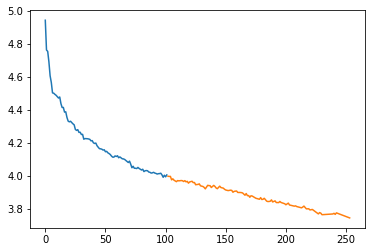

In [19]:
halo_array_masked = np.array(centrals['SubhaloGrNr'])
print("Number of halos with mass > 10^13 Msun: ", len(halo_array_masked))

centrals1 = centrals[:int(len(centrals)/2)]
centrals2 = centrals[int(len(centrals)/2):]

halo_array1 = halo_array_masked[:int(len(halo_array_masked)/2)]
halo_array2 = halo_array_masked[int(len(halo_array_masked)/2):]

plt.plot(halo_array1, np.log10(centrals1['GroupMass']))
plt.plot(halo_array2, np.log10(centrals2['GroupMass']))
print(halo_array1)
print(halo_array2)

In [12]:
import astropy.stats as astats
def Bootstrap_Covariance(NDensity_list, Nb, R):
    halo_array2 = np.arange(0,len(NDensity_list))
    halo_boot = astats.bootstrap(halo_array2, bootnum=300, samples=None)
    resampled_list = []
    for b in range(0,300):
        mask_b = (np.array(halo_boot[b].astype(int)))
        resampled_profile = np.mean((np.array(NDensity_list))[mask_b], axis=0)
        resampled_list.append(resampled_profile)
    resampled_array = np.array(resampled_list)
    Yi = resampled_array
    Yi_avg = np.mean(Yi, axis=0)
    Yi_avg_array = np.tile(Yi_avg, (Nb,1))
    minus_array = Yi - Yi_avg_array
    Yi_cov = np.zeros((R,R))
    for i in range(R):
        for j in range(R):
            Yi_cov[i,j] = (1./(Nb-1.))*(np.sum(minus_array[:,i]*minus_array[:,j]))
    boot_err = np.sqrt(np.diag(Yi_cov))
    return Yi_avg, Yi_cov, boot_err

#SAVITSKY GOLAY LOG DERIVATIVE:
#Functions to get log slope\
#w = 7
#p = 5
def get_slope_sg(xx, yy, num_output, w, p):
    # Savitsky-Golay smoothing
    window_size = w
    poly_order = p
    yy_filtered = signal.savgol_filter(np.log(yy), window_size, poly_order)
    # fit spline
    yy_spline = interpolate.interp1d(np.log(xx), yy_filtered, kind = 'cubic')
    #Evaluate spline on very fine grid
    numsmooth = 1000
    lnxx_fine = np.linspace(np.log(np.min(xx)), np.log(np.max(xx)), num = numsmooth)
    lnyy_fine = yy_spline(lnxx_fine)
    yy_fine = np.exp(lnyy_fine)
    #Calculate derivative using finite differences
    dlny_dlnx_fine = (lnyy_fine[1:] - lnyy_fine[:-1])/(lnxx_fine[1:] - lnxx_fine[:-1])
    #Interpolate derivative onto desired array
    interp_func = interpolate.interp1d(lnxx_fine[:-1], dlny_dlnx_fine)
    lnxx_out = np.linspace(np.min(lnxx_fine[:-1]), np.max(lnxx_fine[:-1]), num = num_output)
    dlny_dlnx_out = interp_func(lnxx_out)
    return np.exp(lnxx_out), dlny_dlnx_out, yy_fine, np.exp(lnxx_fine)

def DensityProfileColors(RScale, Rmin,Rmax,bins,r_subhalo,blue_mask_subs,red_mask_subs,green_mask_subs):    
    # MAKING PROFILE
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1) #3.5 earlier
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    NDensity = []
    NDensity_blue = []
    NDensity_red = []
    NDensity_green = []
    galaxies = []
    galaxies_blue = []
    galaxies_red = []
    galaxies_green = []
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        r_masked = r_subhalo[mask_sep]
        number = len(r_masked)
        delta_r = bin_max[i] - bin_min[i]
        volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3))
        density = number/volume
        r = (bin_min[i] + bin_max[i])/2
        galaxies.append(number)
        NDensity.append(density)
        number_blue=0
        number_red=0
        number_green=0
        if(len(blue_mask_subs) != 0):
            number_blue = len(r_subhalo[mask_sep & blue_mask_subs])
        if(len(red_mask_subs) != 0):    
            number_red = len(r_subhalo[mask_sep & red_mask_subs])
        if(len(green_mask_subs) != 0): 
            number_green = len(r_subhalo[mask_sep & green_mask_subs])

        NDensity_blue.append(number_blue/volume)
        NDensity_red.append(number_red/volume)
        NDensity_green.append(number_green/volume)        
        galaxies_blue.append(number_blue)
        galaxies_red.append(number_red)
        galaxies_green.append(number_green)
    return NDensity, NDensity_blue, NDensity_red, NDensity_green, galaxies, galaxies_blue, galaxies_red, galaxies_green

In [13]:
'''
my version


h_table - halo_table
sh_table - subhalo_table
appended - were additional subhalos outside a certain radius added to halos?
to_print - whether or not to print halo data
returns - Rscale?
cluster_type - string used in title name
'''
def profile(cen_sh, sat_sh, to_print, cluster_type, w, p, bins, cut):
    t0 = time.time()
    Rmin = 0.1
    Rmax, Halo_Rmax = 6,6
    redshift = header['Redshift']
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac

    NDensity_list = []
    NDensity_list_b = []
    NDensity_list_r = []
    NDensity_list_g = []
    RScale_list = []
    red1_ratio = []
    red2_ratio = []

    number_red1DF = []
    number_red2DF = []
    red1_submass = []
    red2_submass= []

    
    for i in range(0,len(cen_sh)):
        
        relevant_subhalos = sat_sh[sat_sh['SubhaloGrNr'] == cen_sh['SubhaloGrNr'][i]]
        
        if(to_print):
            print("\nHalo index:", i)
            print("Halo Mass:", cen_sh['GroupMass'][i])
                
            # TAKING TABLE WITH CLEAN SUBS AFTER MASS CUT AND GETTING FOR DISTANCE
            R500c = 0.001*scale_factor*cen_sh['Group_R_Crit500'][i] #ckpc/h to Mpc/h
            R200c = 0.001*scale_factor*cen_sh['Group_R_Crit200'][i]
            R200m = 0.001*scale_factor*cen_sh['Group_R_Mean200'][i]
            print("R500c, R200c, R200m:",R500c, R200c, R200m)

        RScale = 0.001*scale_factor*cen_sh['Group_R_Mean200'][i]
        RScale_list.append(RScale)
        dev = np.array(relevant_subhalos['SubhaloPos']-cen_sh['GroupPos'][i]) 
        
        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
        r_subhalo_all = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h #has all subhalos > mass cut
        
        # COLOR CUTS
        gmr = relevant_subhalos['SubhaloStellarPhotometrics'][:,4]-relevant_subhalos['SubhaloStellarPhotometrics'][:,5]
        sm = np.log10(relevant_subhalos['StellarMass']*1e10)
        b1,b2 = -0.2, 0.5
        r1, r2 = 0.55, 1.0
        
        blue_mask_subs = (gmr<0.5)
        
        sm1 = 10.2
        color_title = '[%s,%s]' %(r1,sm1)
        
        #if cut == 'subhalomass':
        #    sm = np.log10(relevant_subhalos['SubhaloMass']*1e10)
        #    sm1 = 11.1
            
        red_mask_subs = (gmr>r1)&(sm>=sm1)
        if(len(red_mask_subs)==0):
            print("No reds")
            break
        green_mask_subs = (gmr>r1)&(sm<sm1)
        
        red1_ratio.extend(((relevant_subhalos['SubhaloMass'][red_mask_subs])/(cen_sh['GroupMass'][i])).tolist())
        red2_ratio.extend(((relevant_subhalos['SubhaloMass'][green_mask_subs])/(cen_sh['GroupMass'][i])).tolist())
        red1_submass.extend(relevant_subhalos['SubhaloMass'][red_mask_subs]*1e10)
        red2_submass.extend(relevant_subhalos['SubhaloMass'][green_mask_subs]*1e10)

        NDensity, NDensity_blue, NDensity_red, NDensity_green, galaxies, galaxies_blue, galaxies_red, galaxies_green= DensityProfileColors(
            RScale, Rmin,Rmax,bins,r_subhalo_all,blue_mask_subs, red_mask_subs,green_mask_subs)    

        if(to_print):
            print("galaxies", galaxies)
            print("blue galaxies counted", galaxies_blue)
            print("red1 galaxies counted", galaxies_red)
            print("red2 galaxies counted", galaxies_green)
        number_red1DF.append(sum(galaxies_red))
        number_red2DF.append(sum(galaxies_green))
        NDensity_list.append(NDensity) #/M200m
        NDensity_list_b.append(NDensity_blue)
        NDensity_list_r.append(NDensity_red)
        NDensity_list_g.append(NDensity_green)
        

    # RADIAL BINS, R_AVG, ETC
    R_avg = np.mean(RScale_list) #Mpc/h
    if(to_print):
        print("R_avg:", R_avg)

    bin_divided = np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1)
    bin_stack = (bin_divided[1:]+bin_divided[:-1])/2

    # PLOTTING BASIC AVERAGED STACKS
    NDensity_stack = np.mean(NDensity_list, axis=0)
    NDensity_stack_b = np.mean(NDensity_list_b, axis=0)
    NDensity_stack_r = np.mean(NDensity_list_r, axis=0)
    NDensity_stack_g = np.mean(NDensity_list_g, axis=0)
    plt.figure()
    plt.plot(bin_stack, NDensity_stack, '-')
    plt.plot(bin_stack, NDensity_stack_b, '-')
    plt.plot(bin_stack, NDensity_stack_r, '-')
    plt.plot(bin_stack, NDensity_stack_g, '-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R/R200c')
    plt.ylabel('Galaxy Number Density')
    plt.title('Stacked Profiles of %s Clusters' %(len(cen_sh)), fontweight = 'bold', wrap=True)
    plt.show()

    # BOOTSTRAP PROFILES, ERRORBARS
    Yi_avg, cov, boot_err = Bootstrap_Covariance(NDensity_list, 300, bins)
    Yi_avg_blue, cov_blue, boot_err_blue = Bootstrap_Covariance(NDensity_list_b, 300, bins)
    Yi_avg_red, cov_red, boot_err_red = Bootstrap_Covariance(NDensity_list_r, 300, bins)
    Yi_avg_green, cov_green, boot_err_green = Bootstrap_Covariance(NDensity_list_g, 300, bins)
    dlog_data_SG_x, dlog_data_SG_y, yy_fine, xx_fine = get_slope_sg(bin_stack, (Yi_avg), 1000,w,p)  
    dlog_data_SG_x_b, dlog_data_SG_y_b, yy_fine_b, xx_fine_b = get_slope_sg(bin_stack, (Yi_avg_blue), 1000,w,p)  
    dlog_data_SG_x_r, dlog_data_SG_y_r, yy_fine_r, xx_fine_r = get_slope_sg(bin_stack, (Yi_avg_red), 1000,w,p)  
    dlog_data_SG_x_g, dlog_data_SG_y_g, yy_fine_g, xx_fine_g = get_slope_sg(bin_stack, (Yi_avg_green), 1000,w,p)  
      
    # PLOTTING BOOTSTRAPPED STACKED PROFILES
    plt.figure(figsize=(10,4))
    '''    
    plt.errorbar(bin_stack, Yi_avg*np.sqrt(RScale), yerr = boot_err*np.sqrt(RScale), c = 'slategrey', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
    plt.errorbar(bin_stack, Yi_avg_blue*np.sqrt(RScale), yerr = boot_err_blue*np.sqrt(RScale), c = 'steelblue',ecolor = 'skyblue', elinewidth = 3, capsize=3, label = 'Blue galaxies')
    plt.errorbar(bin_stack, Yi_avg_red*np.sqrt(RScale), yerr = boot_err_red*np.sqrt(RScale), c='firebrick', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red1 galaxies')
    plt.errorbar(bin_stack, Yi_avg_green*np.sqrt(RScale), yerr = boot_err_green*np.sqrt(RScale), c='green', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies')
    

    plt.errorbar(bin_stack, Yi_avg*np.sqrt(bin_stack), yerr = boot_err*np.sqrt(bin_stack), c = 'slategrey', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
    plt.errorbar(bin_stack, Yi_avg_blue*np.sqrt(bin_stack), yerr = boot_err_blue*np.sqrt(bin_stack), c = 'steelblue',ecolor = 'skyblue', elinewidth = 3, capsize=3, label = 'Blue galaxies')
    plt.errorbar(bin_stack, Yi_avg_red*np.sqrt(bin_stack), yerr = boot_err_red*np.sqrt(bin_stack), c='firebrick', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red1 galaxies')
    plt.errorbar(bin_stack, Yi_avg_green*np.sqrt(bin_stack), yerr = boot_err_green*np.sqrt(bin_stack), c='green', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies')
    '''

    plt.errorbar(bin_stack, Yi_avg, yerr = boot_err, c = 'slategrey', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
    plt.errorbar(bin_stack, Yi_avg_blue, yerr = boot_err_blue, c = 'steelblue',ecolor = 'skyblue', elinewidth = 3, capsize=3, label = 'Blue galaxies')
    plt.errorbar(bin_stack, Yi_avg_red, yerr = boot_err_red, c='firebrick', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red1 galaxies')
    plt.errorbar(bin_stack, Yi_avg_green, yerr = boot_err_green, c='green', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R (Mpc/h)')
    plt.ylabel('Galaxy Number Density')# (scaled by M200m)
    plt.title('300-1 Stacked Profile of %s Clusters (ALL SUBHALOS IN DIST)\n (%s Bins)(%s)(Stellar Mass > 10^%s, Color: %s)' 
              %(len(cen_sh), bins, cluster_type ,9, color_title), fontweight = 'bold', wrap=True)
    plt.legend()
    plt.show()

    # SG LOG DERIVATIVE AND PLOT
    plt.figure(figsize = (10,4))
    plt.plot(dlog_data_SG_x, dlog_data_SG_y*np.sqrt(RScale), c = 'slategrey')
    plt.plot(dlog_data_SG_x_b, dlog_data_SG_y_b*np.sqrt(RScale), c = 'steelblue')
    plt.plot(dlog_data_SG_x_r, dlog_data_SG_y_r*np.sqrt(RScale), c = 'firebrick')
    plt.plot(dlog_data_SG_x_g, dlog_data_SG_y_g*np.sqrt(RScale), c = 'green')
    plt.xscale('log')
    plt.xlabel('R (Mpc/h)')
    plt.ylabel('dlog of Number Density')
    plt.show()
    

    return (number_red1DF, number_red2DF, red1_submass, red2_submass, R_avg, cov, cov_blue, cov_red, cov_green, boot_err_blue, boot_err,
            bin_stack, Yi_avg, Yi_avg_blue, Yi_avg_red, Yi_avg_green, dlog_data_SG_x_r, dlog_data_SG_x_g, dlog_data_SG_y_r, 
            dlog_data_SG_y_g, red1_ratio, red2_ratio, boot_err_red, boot_err_green, NDensity_list, NDensity_list_b, NDensity_list_g, NDensity_list_r)


'''

# PLOTTING ALL
# PLOTTING BOOTSTRAPPED STACKED PROFILES
plt.figure(figsize=(10,4))
plt.errorbar(bin_stack11, Yi_avg_red11*np.sqrt(bin_stack11), yerr = boot_err_red1*np.sqrt(bin_stack11), c='firebrick', ecolor = 'firebrick', elinewidth = 3, capsize=3, label = 'Red1 galaxies in low mass clusters', ls='--')
plt.errorbar(bin_stack11, Yi_avg_green11*np.sqrt(bin_stack11), yerr = boot_err_green1*np.sqrt(bin_stack11), c='lawngreen', ecolor = 'lawngreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies in low mass clusters', ls='--')
plt.errorbar(bin_stack12, Yi_avg_red12*np.sqrt(bin_stack12), yerr = boot_err_red2*np.sqrt(bin_stack12), c='indianred', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red1 galaxies in high mass clusters')
plt.errorbar(bin_stack12, Yi_avg_green12*np.sqrt(bin_stack12), yerr = boot_err_green2*np.sqrt(bin_stack12), c='forestgreen', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies in high mass clusters')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R/R200m')
plt.ylabel('Galaxy Number Density')# (scaled by M200m)
plt.title('300-1 Dynamical Friction Test: Stacked Profiles of Clusters (ALL SUBHALOS IN DIST)\n (%s Bins)(Stellar Mass > 10^%s))' %(bins, 7.5), fontweight = 'bold', wrap=True)
plt.legend()

# SG LOG DERIVATIVE AND PLOT
plt.figure(figsize = (10,4))
plt.plot(dlog_data_SG_x_r1, dlog_data_SG_y_r1, c = 'firebrick', ls='--')
plt.plot(dlog_data_SG_x_g1, dlog_data_SG_y_g1, c = 'lawngreen',ls='--')
plt.plot(dlog_data_SG_x_r2, dlog_data_SG_y_r2, c = 'indianred')
plt.plot(dlog_data_SG_x_g2, dlog_data_SG_y_g2, c = 'forestgreen')
plt.xscale('log')
plt.xlabel('R/R200m')
plt.ylabel('dlog of Number Density')
plt.text(3,-4.5,'SG: %s,%s'%(w,p))
plt.ylim(-5,0)


# Dynamical Friction Histograms
plt.figure()
plt.hist(np.log10(red2_ratio1), bins=30, label = 'Red2 - low', density=True, stacked=True, color='lawngreen', histtype='step')
plt.hist(np.log10(red1_ratio1), bins=30, label = 'Red1 - low',density=True,stacked=True,color='firebrick', histtype='step')
plt.hist(np.log10(red2_ratio2), bins=30, label = 'Red2 - high', density=True, stacked=True, color='forestgreen', histtype='step')
plt.hist(np.log10(red1_ratio2), bins=30, label = 'Red1 - high',density=True,stacked=True,color='indianred', histtype='step')
plt.xlabel('Log Scaled Ratio of SubhaloMass to GroupMass')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Subhalo Mass/Halo Mass Ratio (Stellar Mass > 10^%s))' %(7.5))
plt.legend()

plt.figure()
plt.hist(np.log10(red2_ratio1), bins=30, label = 'Red2 - low', density=False, stacked=True, color = 'lawngreen', histtype='step')
plt.hist(np.log10(red1_ratio1), bins=30, label = 'Red1 - low',density=False,stacked=True, color='firebrick', histtype='step')
plt.hist(np.log10(red2_ratio2), bins=30, label = 'Red2 - high', density=False, stacked=True, color = 'forestgreen', histtype='step')
plt.hist(np.log10(red1_ratio2), bins=30, label = 'Red1 - high',density=False,stacked=True, color='indianred', histtype='step')
plt.xlabel('Log Scaled Ratio of SubhaloMass to GroupMass')
plt.ylabel('Count')
plt.title('Histogram of Subhalo Mass/Halo Mass Ratio (Stellar Mass > 10^%s)' %(7.5))
plt.legend()
'''


"\n\n# PLOTTING ALL\n# PLOTTING BOOTSTRAPPED STACKED PROFILES\nplt.figure(figsize=(10,4))\nplt.errorbar(bin_stack11, Yi_avg_red11*np.sqrt(bin_stack11), yerr = boot_err_red1*np.sqrt(bin_stack11), c='firebrick', ecolor = 'firebrick', elinewidth = 3, capsize=3, label = 'Red1 galaxies in low mass clusters', ls='--')\nplt.errorbar(bin_stack11, Yi_avg_green11*np.sqrt(bin_stack11), yerr = boot_err_green1*np.sqrt(bin_stack11), c='lawngreen', ecolor = 'lawngreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies in low mass clusters', ls='--')\nplt.errorbar(bin_stack12, Yi_avg_red12*np.sqrt(bin_stack12), yerr = boot_err_red2*np.sqrt(bin_stack12), c='indianred', ecolor = 'indianred', elinewidth = 3, capsize=3, label = 'Red1 galaxies in high mass clusters')\nplt.errorbar(bin_stack12, Yi_avg_green12*np.sqrt(bin_stack12), yerr = boot_err_green2*np.sqrt(bin_stack12), c='forestgreen', ecolor = 'forestgreen', elinewidth = 3, capsize=3, label = 'Red2 galaxies in high mass clusters')\nplt.xscale('log')

## Run Profiles

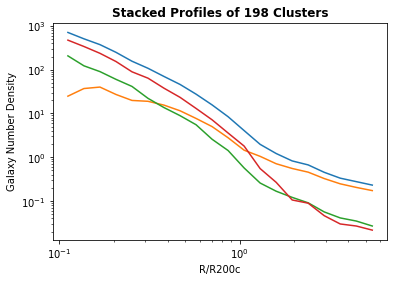

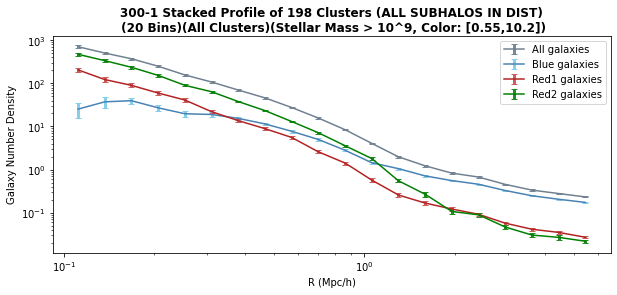

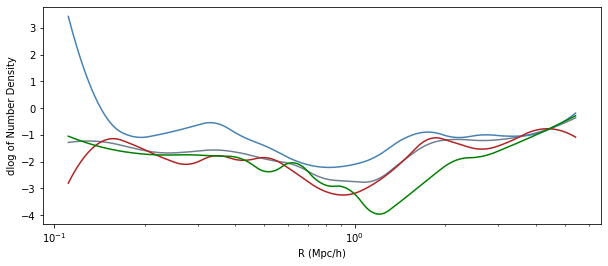

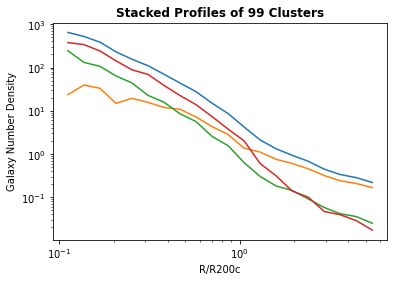

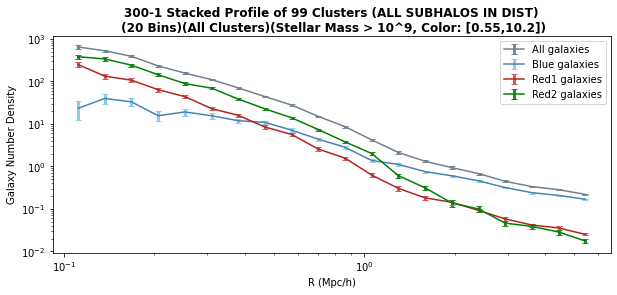

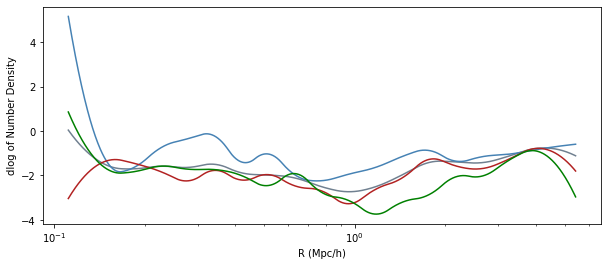

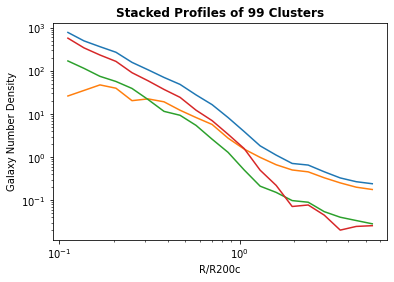

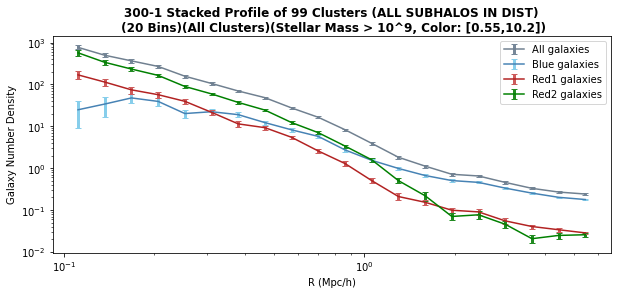

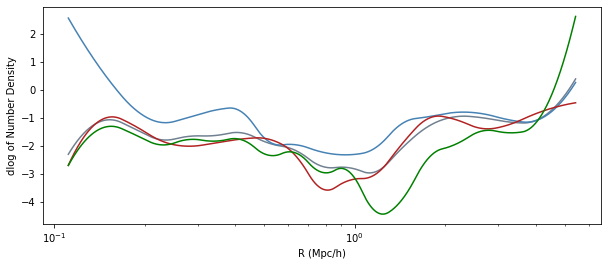

In [14]:
w,p = 9,5
bins = 20 

number_red1DF, number_red2DF, red1_submass, red2_submass, R_avg, cov, cov_blue, cov_red, cov_green, boot_err_blue, boot_err, bin_stack, Yi_avg, Yi_avg_blue, Yi_avg_red, Yi_avg_green, dlog_data_SG_x_r, dlog_data_SG_x_g, dlog_data_SG_y_r, dlog_data_SG_y_g, red1_ratio, red2_ratio, boot_err_red, boot_err_green, NDensity_list, NDensity_list_b, NDensity_list_g, NDensity_list_r = profile(centrals, satellites, False, "All Clusters", w, p, bins, 'stellarmass')

number_red1DF11, number_red2DF11, red1_submass11, red2_submass11, R_avg11, cov11, cov_blue11, cov_red11, cov_green11, boot_err_blue11, boot_err11, bin_stack11, Yi_avg11, Yi_avg_blue11, Yi_avg_red11, Yi_avg_green11, dlog_data_SG_x_r1, dlog_data_SG_x_g1, dlog_data_SG_y_r1, dlog_data_SG_y_g1, red1_ratio1, red2_ratio1, boot_err_red1, boot_err_green1, NDensity_list_1, NDensity_list_b_1, NDensity_list_g_1, NDensity_list_r_1 = profile(centrals1, satellites, False, "All Clusters", w, p, bins, 'stellarmass')

number_red1DF12, number_red2DF12, red1_submass12, red2_submass12, R_avg12, cov12, cov_blue12, cov_red12, cov_green12, boot_err_blue12, boot_err12, bin_stack12, Yi_avg12, Yi_avg_blue12, Yi_avg_red12, Yi_avg_green12, dlog_data_SG_x_r2, dlog_data_SG_x_g2, dlog_data_SG_y_r2, dlog_data_SG_y_g2, red1_ratio2, red2_ratio2, boot_err_red2, boot_err_green2, NDensity_list_2, NDensity_list_b_2, NDensity_list_g_2, NDensity_list_r_2 = profile(centrals2, satellites, False, "All Clusters", w, p, bins, 'stellarmass')


In [15]:
# PROFILE FITTING FUNCTIONS
import emcee
import scipy

r_0 = 1.5 # Fix r_0 to 1.5 Mpc/h
#rho_g= 0.027543187127290668 #(Mpc/h)^-3
#rho_g= 0.026943079757983778
#rho_g_b= 0.021698698509888134
#rho_g_r= 0.0029584016482639545
#rho_g_g= 0.0022859795998316913
# Define halo profile model

def rho_DK14(theta, r, rho_g_i):
    """
    Definition of halo profile model from Diemer Kravstov 2014
    r_s, r_t, r must all be in units of kpc/h
    """
    
    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
   
    def rho_inner(r):
        exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
        return rho_s*np.exp(exp_arg)

    def rho_outer(r):
        return rho_0*((r/r_0)**(-s_e)) + rho_g_i

    def f_trans(r):
        return (1+(r/r_t)**beta)**(-gamma/beta)
    
    return rho_inner(r)*f_trans(r)+rho_outer(r)

    
def ln_like3d(theta,  r_data, rho_data, cov, rho_g_i):
    """
    Definition of log-likelihood using DK14 moel
    """
    
    rho_thr = rho_DK14(theta, r_data, rho_g_i)
    diff = rho_data-rho_thr
    
    likelihood = -1/2 * np.dot(diff, np.linalg.solve(cov, diff))
    
    if (np.isnan(likelihood)==True):
        return -np.inf

    return likelihood


def ln_prior(theta):
    """
    Definition of parameter priors
    """

    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
    
    # Top hat prior on r_s, r_t, s_e
    #r_s_check = (r_s > 0.01) & (r_s < 5)#(r_s > 0.1) & (r_s < 5000) #Blues #most stuff before Blues run with .01
    r_s_check = (r_s > 0.01) & (r_s < 5) #FOR BLUES PROFILES
    r_t_check = (r_t > 0.01) & (r_t < 50)
    s_e_check = (s_e > 0.3) & (s_e < 5)

    rho_s_check =(rho_s >= 0.0001) & (rho_s < 5000)
    #rho_s_check = True
    rho_0_check = True

    flat_prior_check = r_s_check & r_t_check & s_e_check & rho_s_check & rho_0_check 
    
    if not flat_prior_check:
        return -np.inf

    return  -0.5*(lg_alpha - np.log10(0.19))**2/0.2**2 - 0.5*(lg_beta - np.log10(6.0))**2/0.6**2 - 0.5*(lg_gamma - np.log10(4.0))**2/0.6**2
    

def ln_prob3d(theta, r, rho, cov, rho_g_i):
    """
    Total probability definition (likelihood+prior)
    """
    lp = ln_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf

    return lp+ln_like3d(theta, r, rho, cov, rho_g_i)


def main(p0,n_walkers,n_iter,n_dim,n_burn,ln_prob, data):
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_prob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, n_burn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, n_iter, progress=True)

    return sampler, pos, prob, state

def MCMC(averaged_r_tot, profiles, covs,rho_g_list,init_theta, bounds, n_burn, n_walkers, n_iter):
    labels = [r'$\log(\alpha)$', r'$\log(\beta)$', r'$\log(\gamma)$', r'$\log(r_s)$', r'$\log(r_t)$', r'$\log(\rho_s)$', r'$\log(\rho_0)$', r'$s_e$']
    best_fit_mcmc_list = []#[best_fit_mcmc, best_fit_mcmc_blue, best_fit_mcmc_red, best_fit_mcmc_green]
    samples_list = []
    #rho_g_list = [0.026943079757983778, 0.021698698509888134, 0.0029584016482639545, 0.0022859795998316913]
    for i in range(len(profiles)):
        averaged_r_tot = averaged_r_tot #in Mpc/h
        averaged_rho_tot = profiles[i] #- rho_g_list[i]#Yi_avg1
        rho_g_i = rho_g_list[i]
        cov = covs[i]

        # Fit TNG_300-1 Profiles
        data = [averaged_r_tot, averaged_rho_tot, cov,rho_g_i]
        args = (averaged_r_tot, averaged_rho_tot, cov,rho_g_i)
        # Set initial guess and boundaries and use minimization to determine start position of MCMC chain
        #lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
        #init_theta = np.array([-0.50257944, 0.58536, 0.90564052,  -0.5, 0.35784823, 13.8549328, 8.051313892 , 1.30773031])
        #init_theta = np.array([-.92, 0.78, 0.60, -0.61, 0.34, 2.7, -.3 , 1.66])
        ndim = 8 #number of free parameters
        neg_ll3d = lambda *args: -ln_like3d(*args)

        res = scipy.optimize.minimize(neg_ll3d, init_theta, args=args, method='SLSQP', options = {'maxiter':500}, bounds=bounds)

        # Run MCMC
        n_burn = n_burn#10000#500?? or 1000
        n_dim, n_walkers = 8, n_walkers#128#128 #increasing walkers from 500 to 1000 seemed to help, maybe return n_iter and n_burn to lower values
        n_iter = n_iter#5000
        # WORKED with 5000,8,200,10000. pretty good with 1000 for burn. 
        # BEST is 10000,8,128,5000 takes 280 seconds for main part 
        p0 = [res.x + 1e-3*np.random.randn(n_dim) for i in range(n_walkers)]
        sampler, pos, prob, state = main(p0, n_walkers, n_iter, n_dim, n_burn,ln_prob3d, data)
        samples = sampler.flatchain
        corner.corner(samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True);
        samples_list.append(samples)
        best_fit_mcmc_list.append(samples[np.argmax(sampler.flatlnprobability)])

    print('done MCMC')
    return best_fit_mcmc_list, samples

def FittedPlots(best_fit_mcmc_list_DF, profiles, averaged_r_tot,Ravg, covs,rho_g_list,labels, colors, ls_list):
    plt.figure(figsize=(10,13))#(20,28))
    ax0 = plt.subplot(3,1,1)
    ax1 = plt.subplot(3,1,2)
    ax2 = plt.subplot(3,1,3)
    
    plt.tight_layout()
    halo_masses = []
    for h_i in range(0,len(centrals)):
        halo_masses.append(halo_grp['GroupMass'][h_i]*1e10)
    r_sp_list = []
    r_sp_r200_list = []
    bins = 20
    for i in range(len(colors)):
        best_fit_mcmc = best_fit_mcmc_list_DF[i]
        averaged_rho_tot = profiles[i]
        r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 3000)

        log_deriv_mcmc = r_thr/rho_DK14(best_fit_mcmc,r_thr, rho_g_list[i])*np.gradient(rho_DK14(best_fit_mcmc,r_thr, rho_g_list[i]), r_thr)

        r_sp = r_thr[np.argmin(log_deriv_mcmc)]
        r_sp_r200 = r_sp/Ravg
        r_sp_list.append(r_sp)
        r_sp_r200_list.append(r_sp_r200)
        
        bins0 = np.logspace(np.min(np.log10(halo_masses)), 
                           np.max(np.log10(halo_masses)), 30)

        ax0.hist(halo_masses, bins=bins0, color = 'cadetblue')
        title_str = r"Mass Distribution of %s Clusters ($\overline{m}$= " % (len(centrals))
        title_str += ("{:.3E} $M\odot$)").format(np.mean(halo_masses))
        ax0.set_title(title_str+' (Minimum = 5*10$^{13}$)', fontweight="bold")
        ax0.set_xlabel(r"Cluster Mass ($M_{\odot}$)")
        ax0.set_ylabel("Count")
        ax0.set_xscale("log")
        ax0.set_yscale("log")

        
        #plt.subplot(3,1,2)
        Min = min(averaged_r_tot)/Ravg
        Max = max(averaged_r_tot)/Ravg
        ax1.plot(r_thr/Ravg, rho_DK14(best_fit_mcmc, r_thr, rho_g_list[i]), color=colors[i], linestyle=ls_list[i] 
                 , label="Model Fit %s" %(labels[i]))
        ax1.errorbar(averaged_r_tot/Ravg, averaged_rho_tot, 
                     yerr=np.sqrt(np.diag(covs[i])), 
                     marker = '.', color = colors[i], linestyle = "none",
                     markersize = 5, ecolor = colors[i], elinewidth = 1, capsize=2, 
                     markeredgewidth=1, label="Data %s" %(labels[i]))
        #plt.errorbar(bin_stack1, Yi_avg1, yerr = boot_err1, c = 'slategray', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
        ax1.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])
        ax1.legend(frameon=False, loc="upper right")
        ax1.set_title("300-1 Galaxy Number Density Profiles (Subhalos > 10$^{9}$, Bins = %s)" %(bins), fontweight="bold")
        ax1.set_xlabel('r/R200m')#(r"$r$ [h$^{-1}$Mpc]")
        ax1.set_ylabel(r"$\rho$ [$M_{\odot}h^3$Mpc$^{-3}$]")
        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlim(Min,Max)#(0.08, 3) #2


        #plt.subplot(3,1,3)
        ax2.plot(r_thr/Ravg, log_deriv_mcmc, label='Rsp = %s , %s (Mpc/h)' %("{:.5f}".format(r_sp_r200),"{:.5f}".format(r_sp)), color=colors[i], linestyle=ls_list[i])
        ax2.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])
        ax2.set_xscale("log")
        ax2.set_title("Log Derivatives of Model Fits", fontweight="bold", color="k")
        ax2.set_xlabel('r/R200m')#(r"$r$ [h$^{-1}$Mpc]")
        ax2.set_ylabel(r"$d\log \rho / d \log r$")
        ax2.set_xlim(Min,Max)#(0.08, 3) #2
        ax2.set_ylim(-7.5, -0.5)
        ax2.legend(frameon=False, loc="lower right")
        

    plt.tight_layout()
    plt.show()
    return r_sp_list, r_sp_r200_list



## MCMC

Running burn-in...


<ipython-input-15-28fb912255c3>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
<ipython-input-15-28fb912255c3>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)


Running production...


Running burn-in...


<ipython-input-15-28fb912255c3>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)


Running production...


Running burn-in...


<ipython-input-15-28fb912255c3>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
<ipython-input-15-28fb912255c3>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)


Running production...


Running burn-in...


<ipython-input-15-28fb912255c3>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
<ipython-input-15-28fb912255c3>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)


Running production...


done MCMC
882.9709129333496


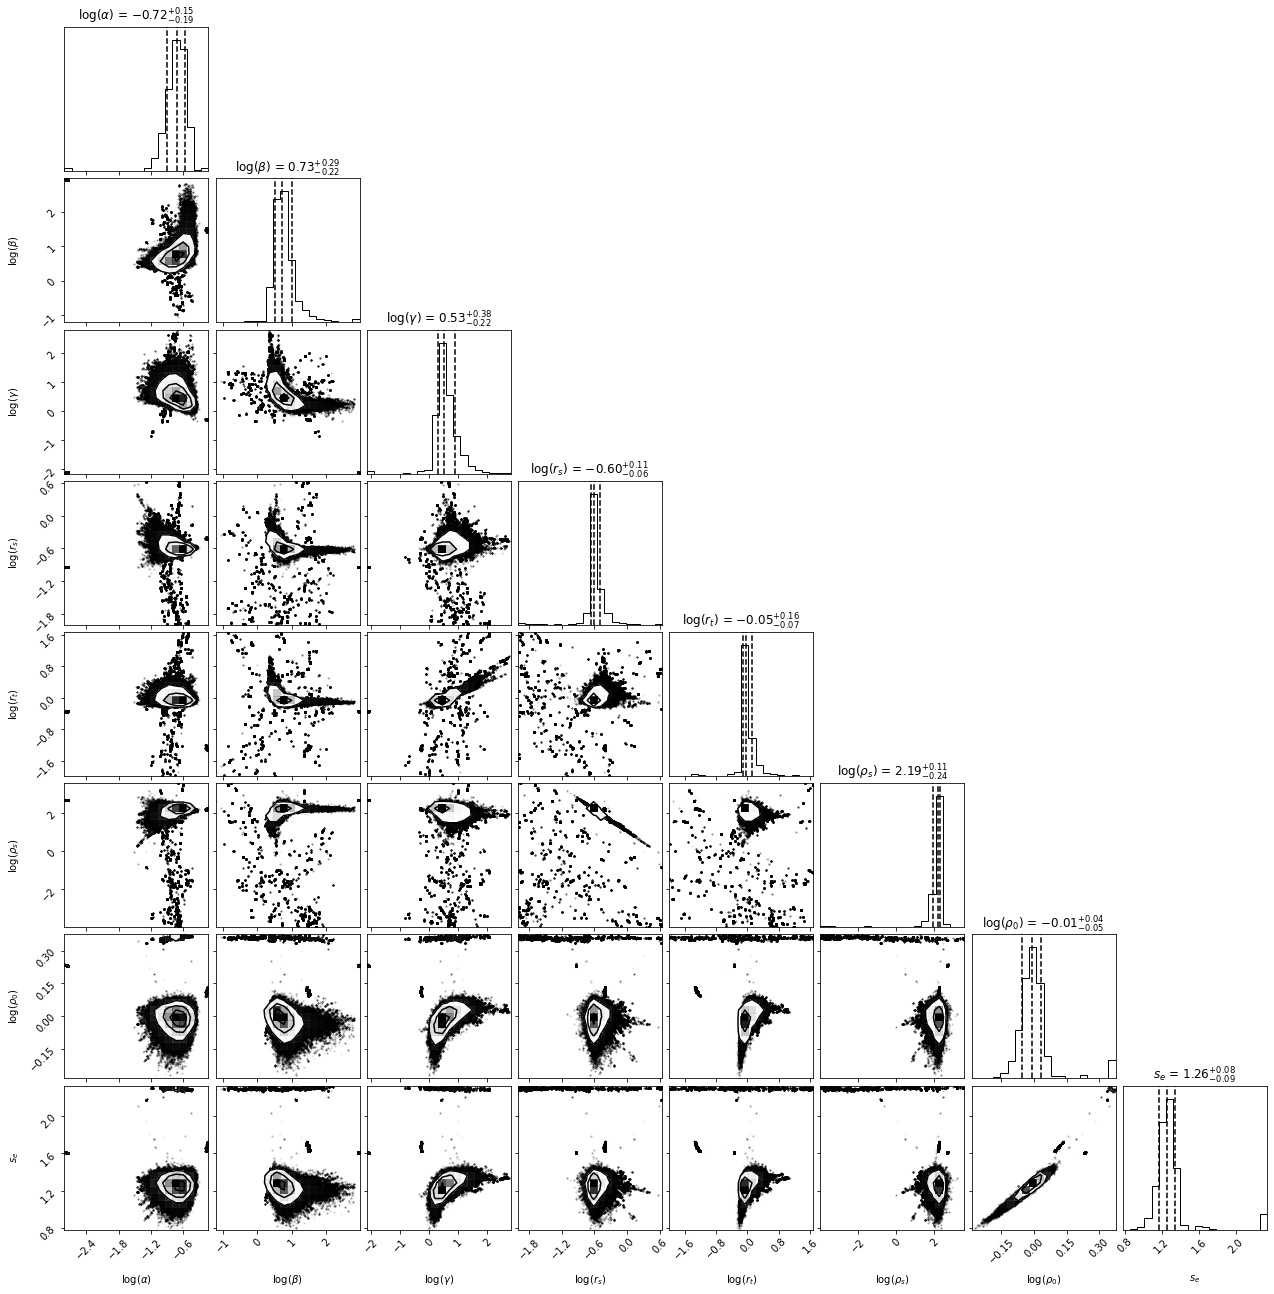

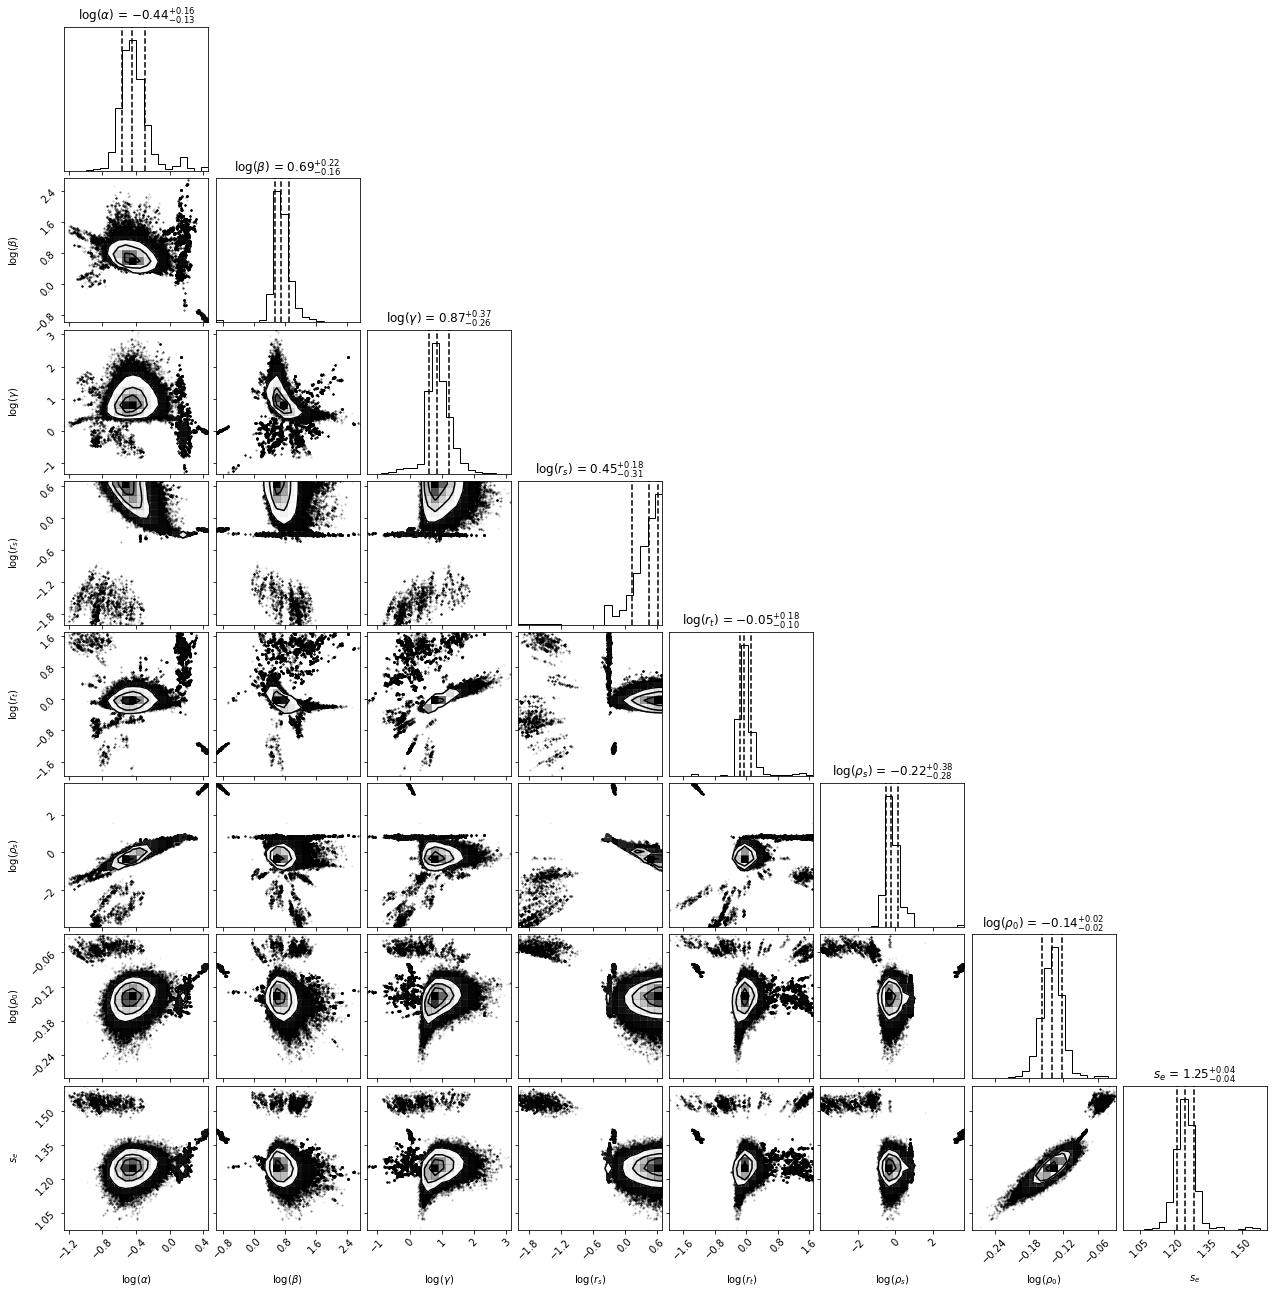

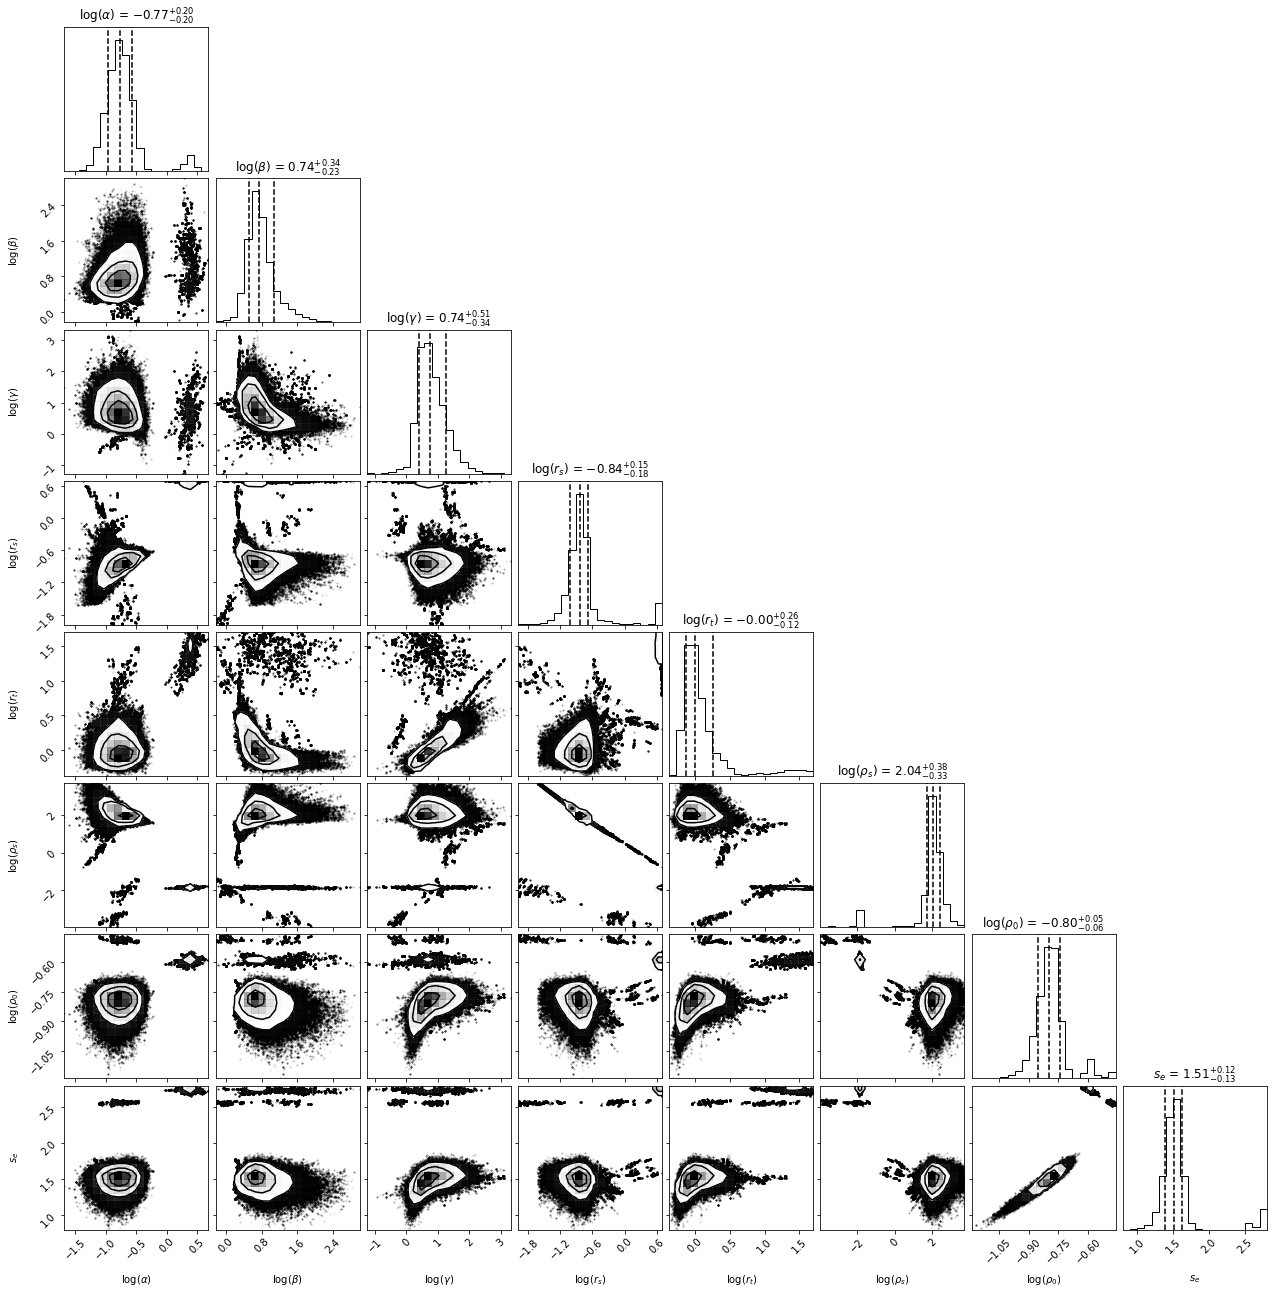

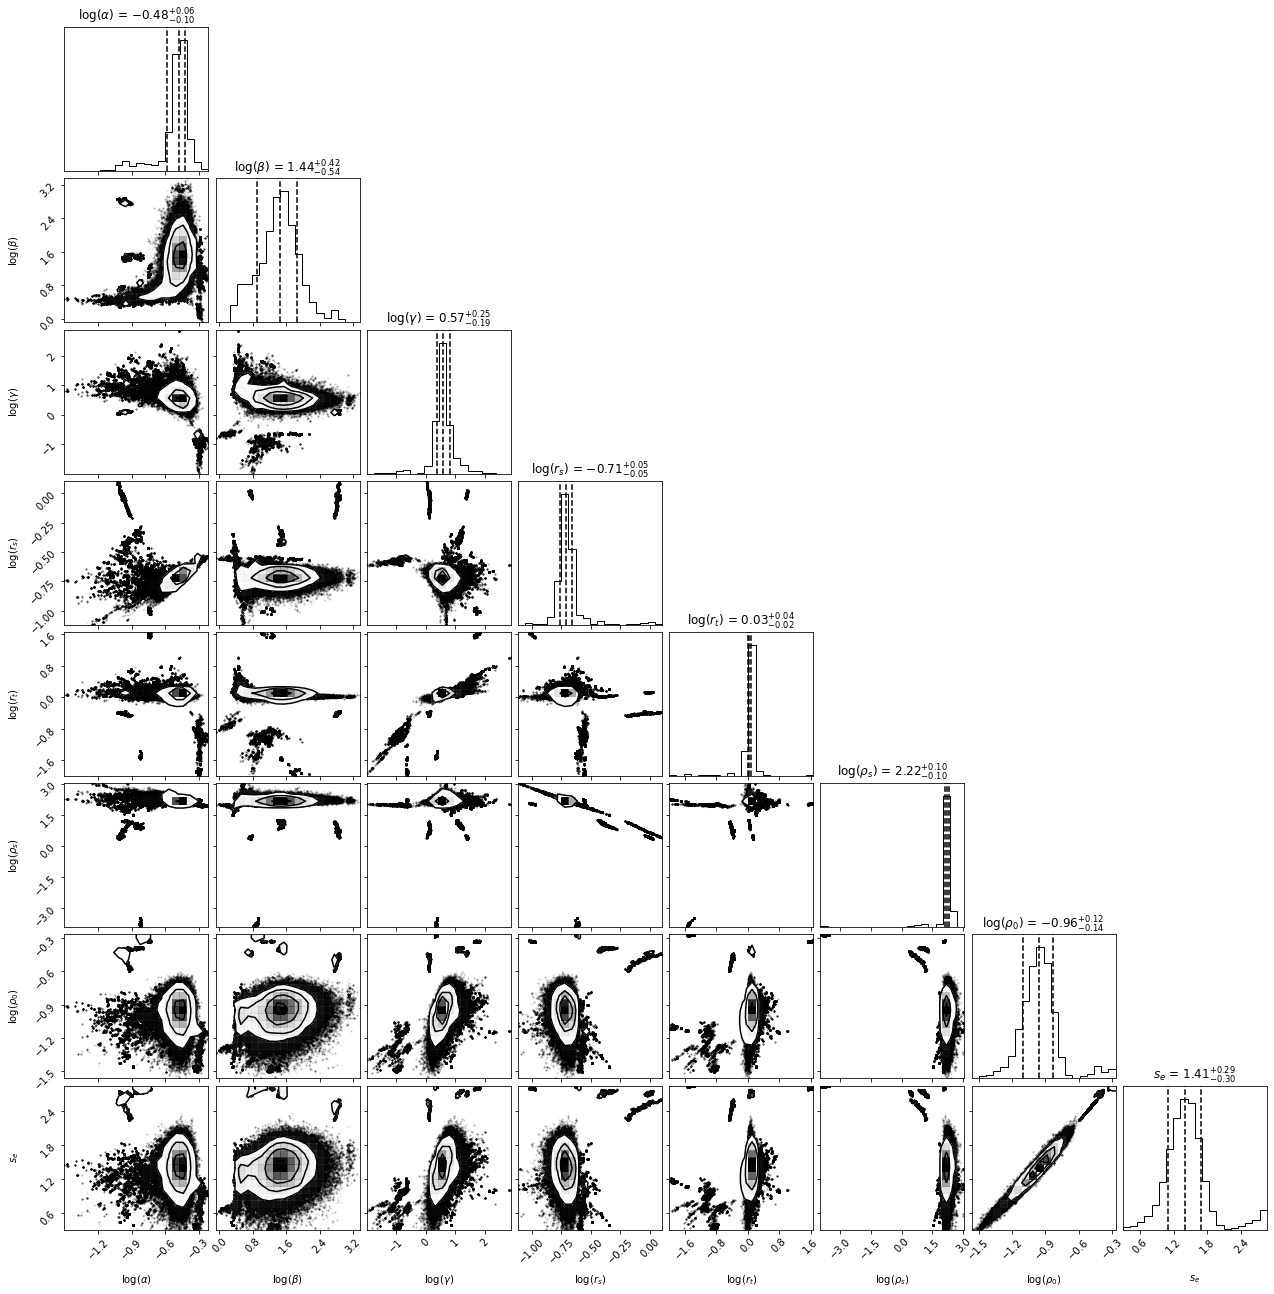

In [16]:
'''
return (sh_ids,number_red1DF, number_red2DF, red1_submass, red2_submass, R_avg, cov, cov_blue, cov_red, cov_green, boot_err_blue, boot_err,
            bin_stack, Yi_avg, Yi_avg_blue, Yi_avg_red, Yi_avg_green, dlog_data_SG_x_r, dlog_data_SG_x_g, dlog_data_SG_y_r, 
            dlog_data_SG_y_g, red1_ratio, red2_ratio, boot_err_red, boot_err_green, NDensity_list, NDensity_list_b, NDensity_list_g, NDensity_list_r)
'''
t0 = time.time()

import corner

profiles = [Yi_avg, Yi_avg_blue, Yi_avg_red,Yi_avg_green]
covs = [cov, cov_blue, cov_red,cov_green]


init_theta = np.array([-.92, 0.78, 0.60, -0.61, 0.34, 2, 3 , 1.66])
bounds = ((-2, 2),(-1.4, 3), (-1.2,3), (-2, 0.7), (-2, 0.7), (-1, 30), (-1, 30), (.1, 10))
#rho_g_list = [0.026943079757983778, 0.021698698509888134, 0.0029584016482639545, 0.0022859795998316913]

best_fit_mcmc_list, samples = MCMC(bin_stack, profiles, covs,rho_g_list,init_theta, bounds, 15000, 128, 5000)    
#change priors on p_s to less? change priors on r_s a little?
print(time.time() - t0)

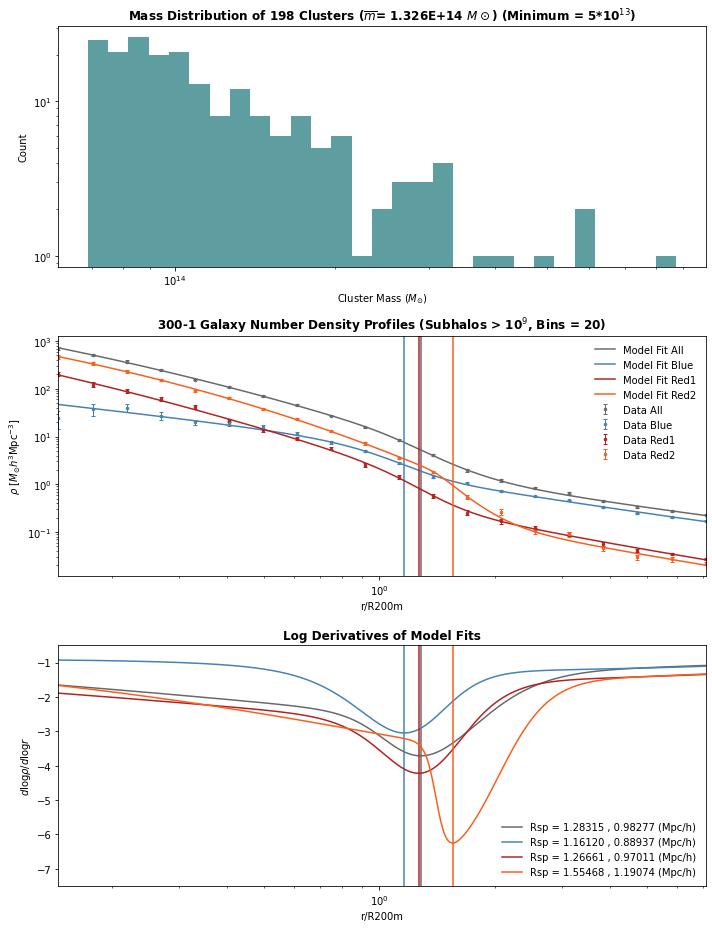

[0.9827737774964048, 0.8893687145970519, 0.9701097516916015, 1.1907411707295885]


In [17]:
# MCMC FITTING COLOR SPLIT PROFILES
colors = ['dimgray','steelblue','firebrick','#fa5f1b']
labels = ['All','Blue','Red1','Red2']
ls_list = ['-','-','-','-']
averaged_r_tot = bin_stack
r_sp_list, r_sp_r200_list = FittedPlots(best_fit_mcmc_list, profiles, averaged_r_tot,R_avg,covs,rho_g_list,labels, colors, ls_list)
print(r_sp_list)

# Properties

In [12]:
sats = [satellites, satellites_red, satellites_green, satellites_blue]
color = ["all", "red", "red2", "blue"]
def property_plotter(prop1, prop2, xlab, ylab, table_name):
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)

    ax_main.hist2d(prop1, prop2, bins=80, cmap='viridis', cmin=5) #, range=[[9,12], [0,1]])
    ax_main.set_xlabel(xlab, fontsize=20)
    ax_main.set_ylabel(ylab, fontsize=20)

    ax_x.hist(prop1,bins=50,align='mid', histtype='step', color = 'green')
    ax_x.set(ylabel='count')
    ax_x.set_title(table_name, fontsize = 20)
    ax_y.hist(prop2,bins=50,orientation='horizontal',align='mid', histtype='step', color = 'red')
    ax_y.set(xlabel='count')
    plt.show()

## Metallicity

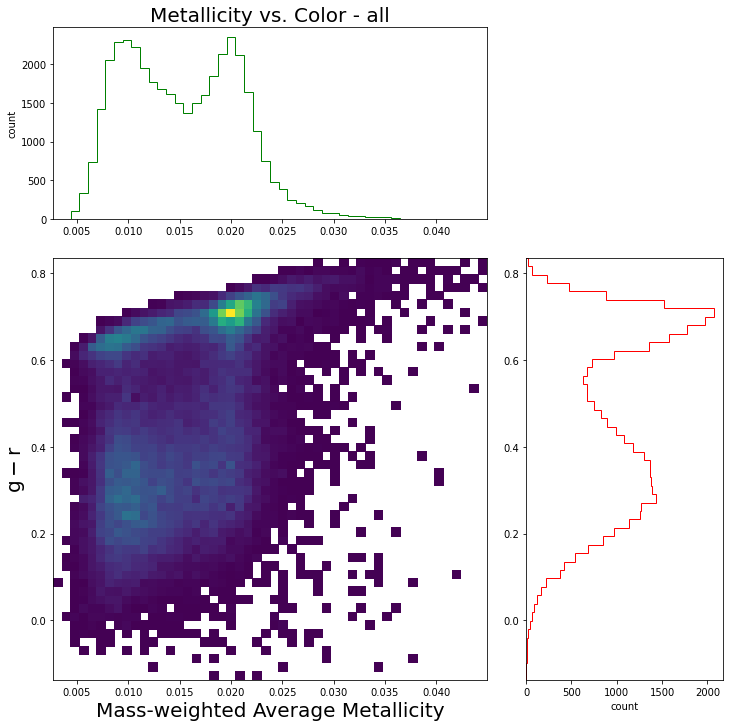

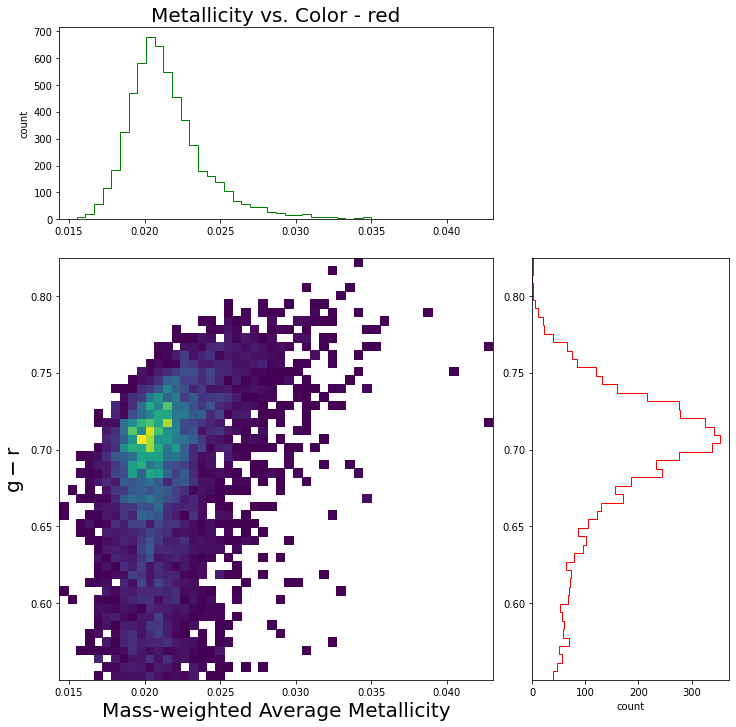

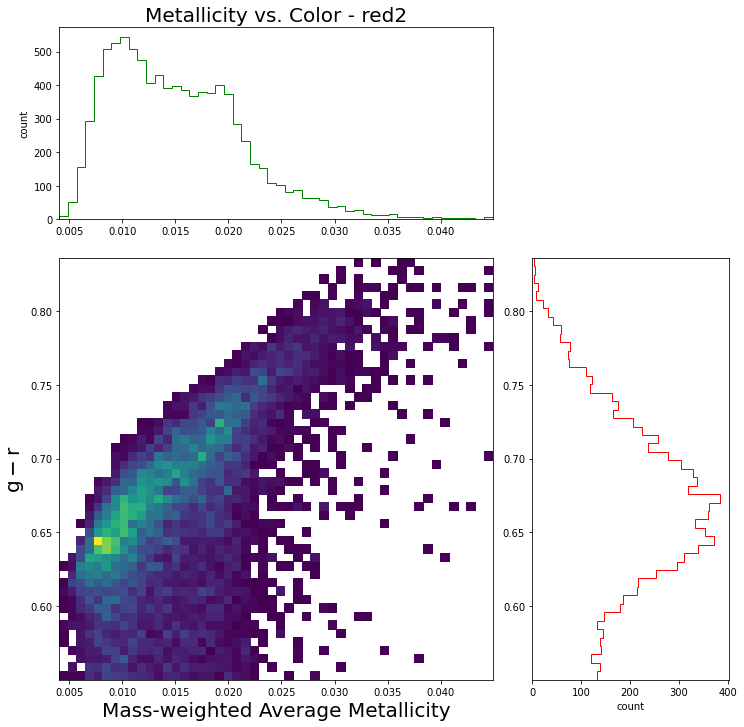

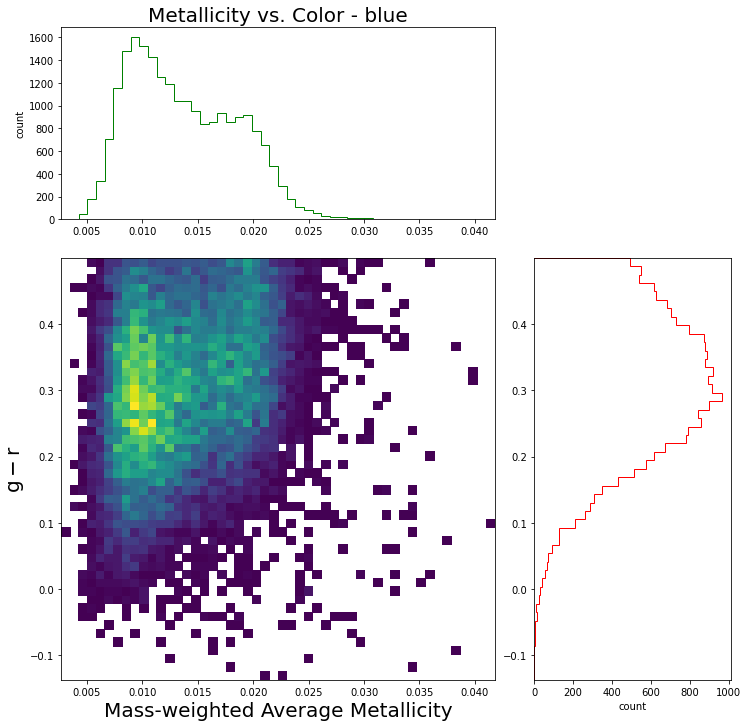

In [16]:
for i in range(0,4):
    mag = sats[i]['SubhaloStellarPhotometrics'][:,4] - sats[i]['SubhaloStellarPhotometrics'][:,5]
    metal = sats[i]['SubhaloStarMetallicity']
    mag = mag[metal<0.045]
    metal = metal[metal<0.045]
    property_plotter(metal, mag, 'Mass-weighted Average Metallicity', "$\mathrm{g-r}$", "Metallicity vs. Color - " + color[i])


## Color Density - g-r band

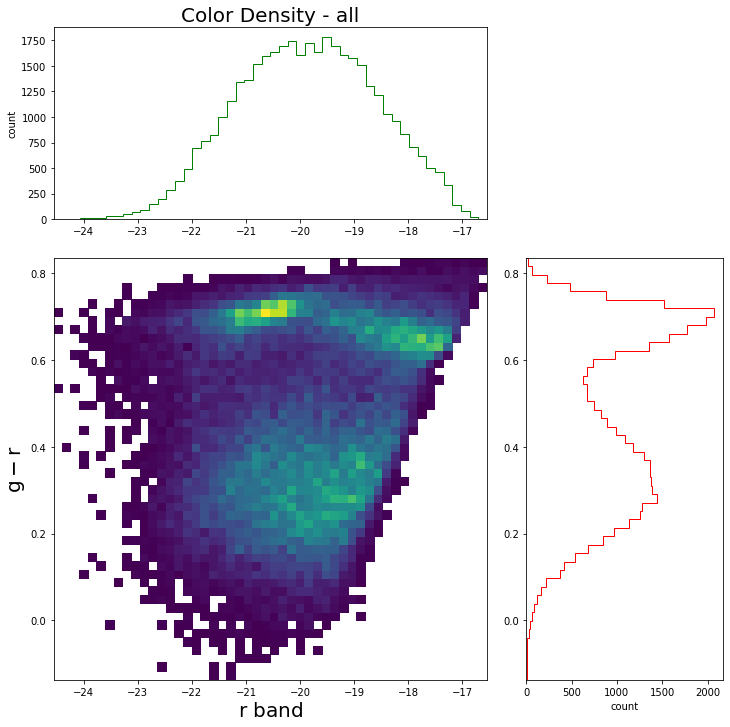

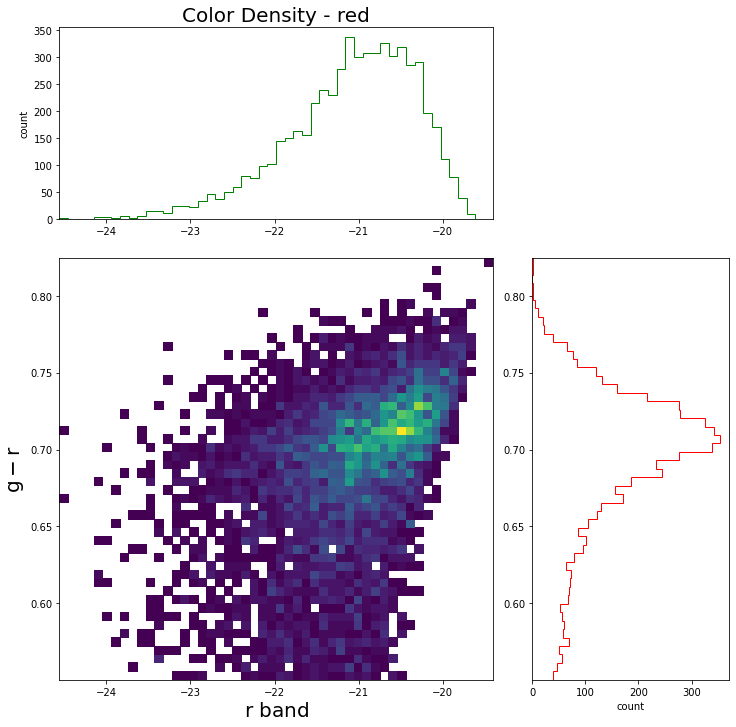

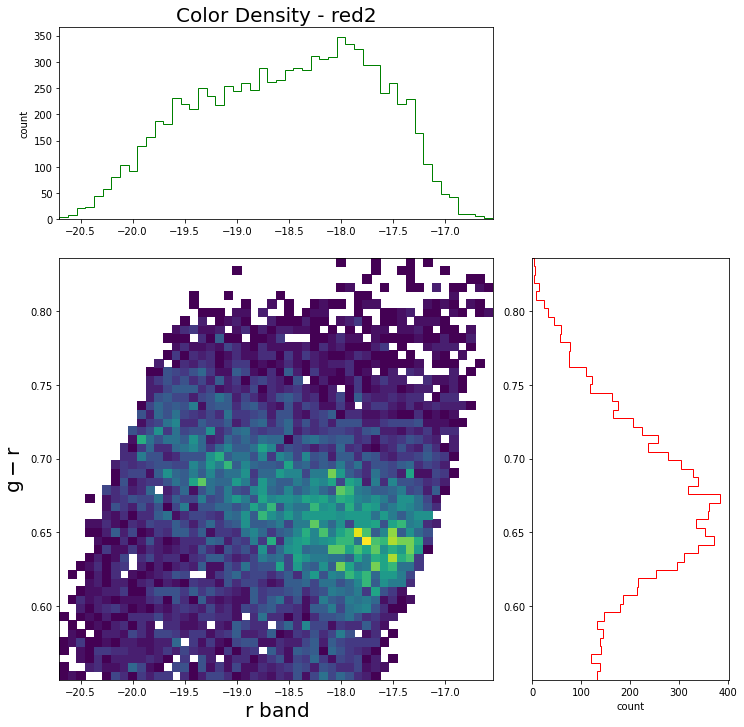

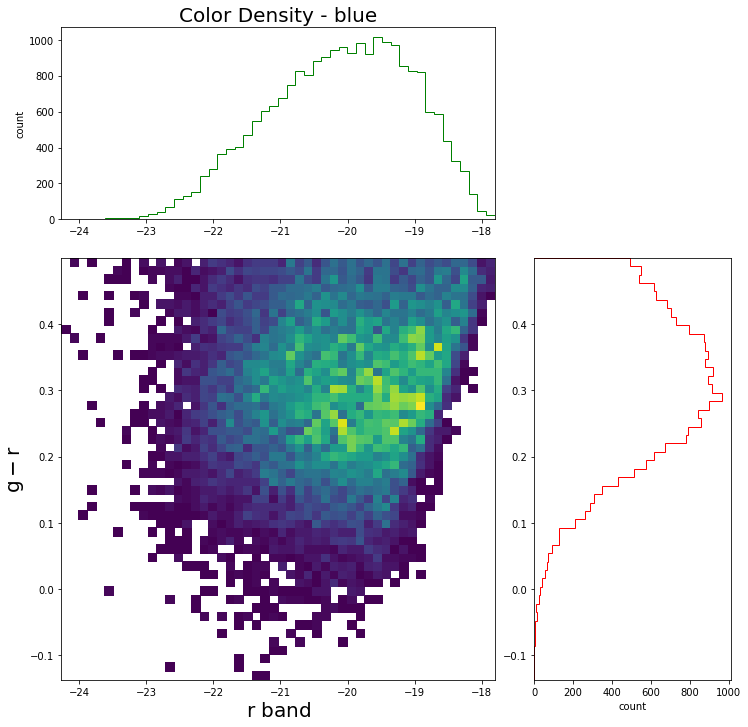

In [17]:
for i in range(0,4):
    mag = sats[i]['SubhaloStellarPhotometrics'][:,4] - sats[i]['SubhaloStellarPhotometrics'][:,5]
    r = sats[i]['SubhaloStellarPhotometrics'][:,4]
    property_plotter(r, mag, '$\mathrm{r}$ band', "$\mathrm{g-r}$", "Color Density - " + color[i])

## Color Density - g-i  and   i

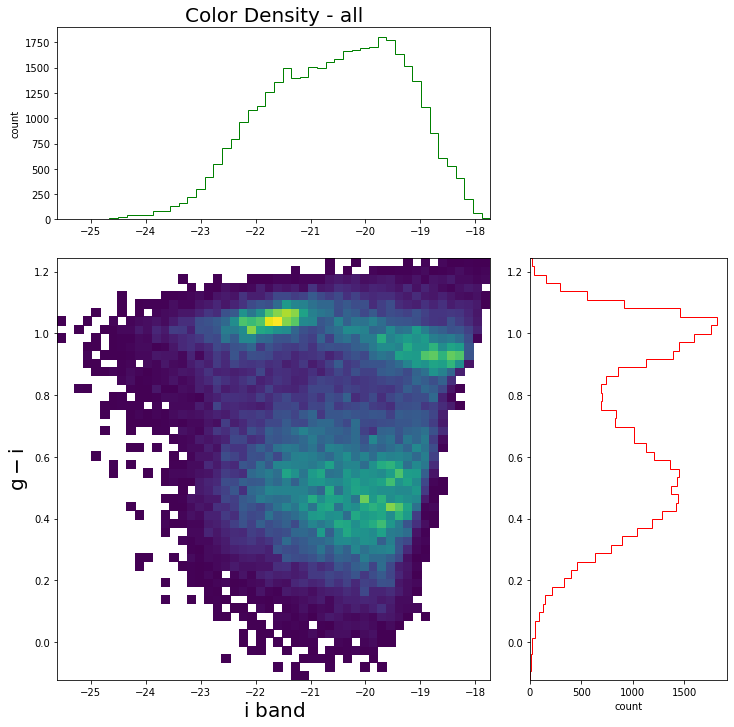

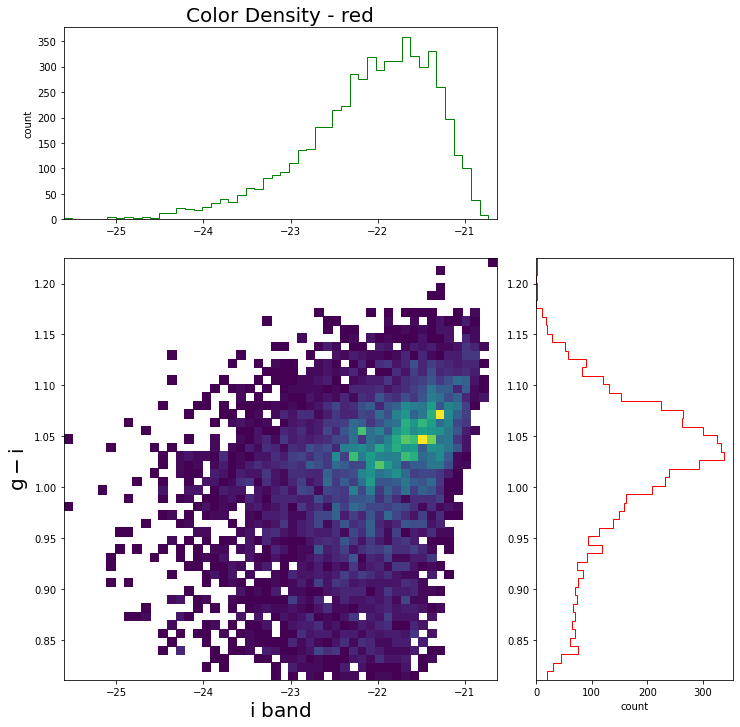

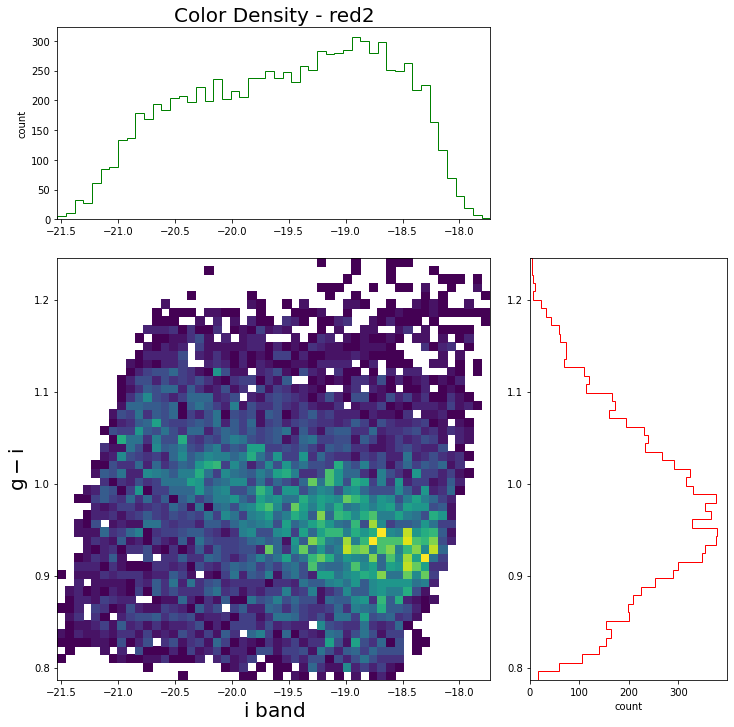

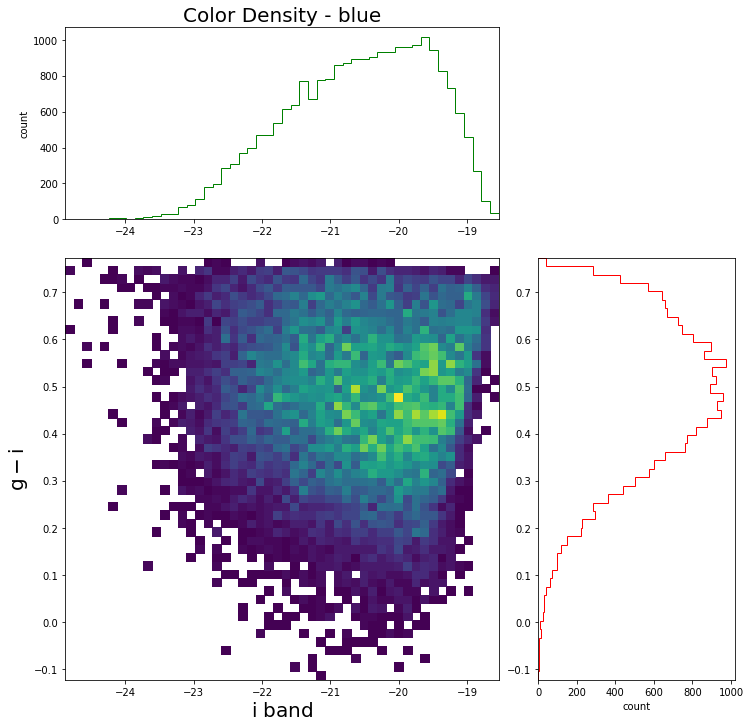

In [18]:
for i in range(0,4):
    mag = sats[i]['SubhaloStellarPhotometrics'][:,4] - sats[i]['SubhaloStellarPhotometrics'][:,6]
    i_band = sats[i]['SubhaloStellarPhotometrics'][:,6]
    property_plotter(i_band, mag, '$\mathrm{i}$ band', "$\mathrm{g-i}$", "Color Density - " + color[i])

## Color Density - r-i and i 

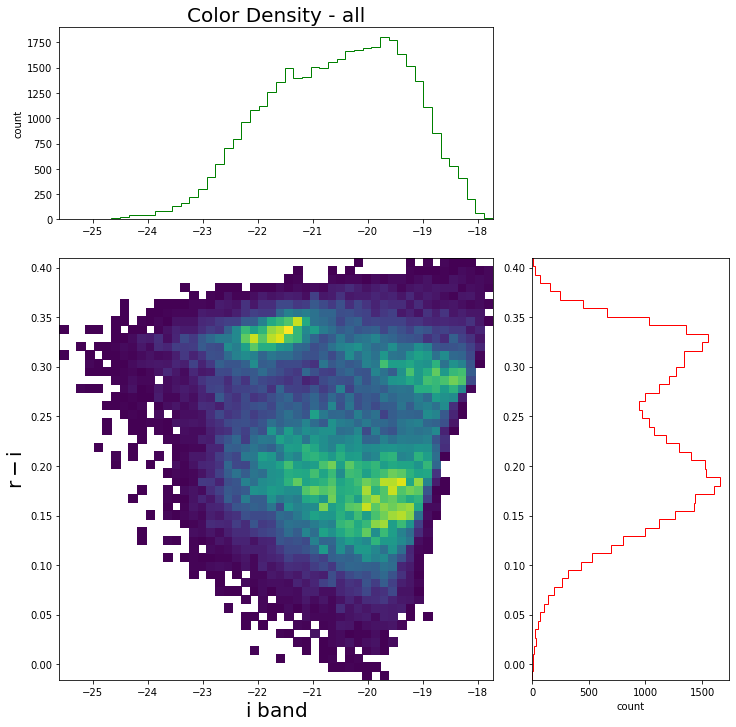

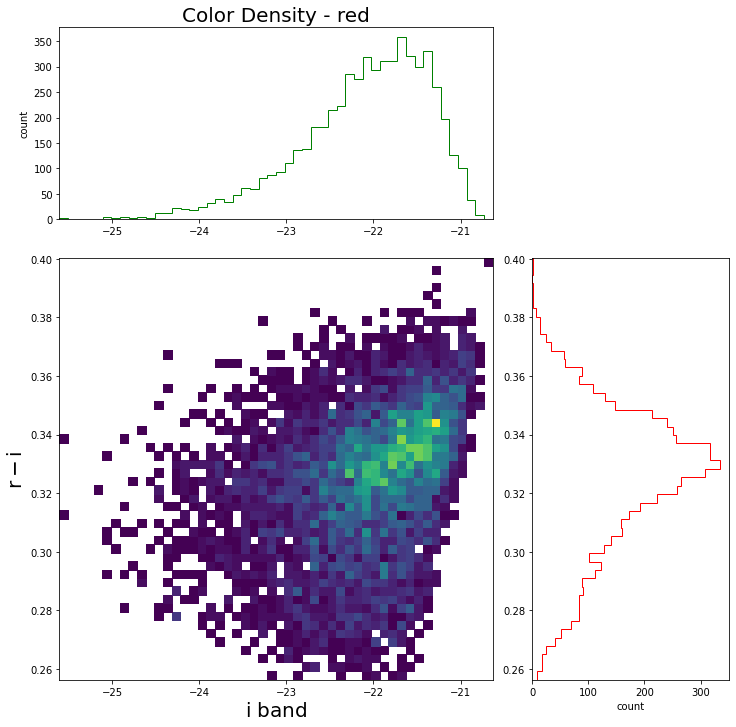

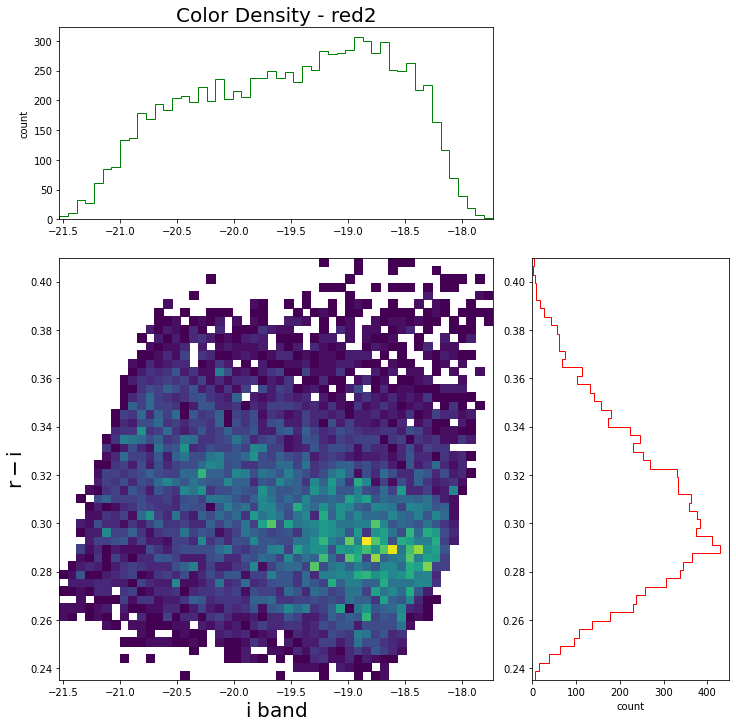

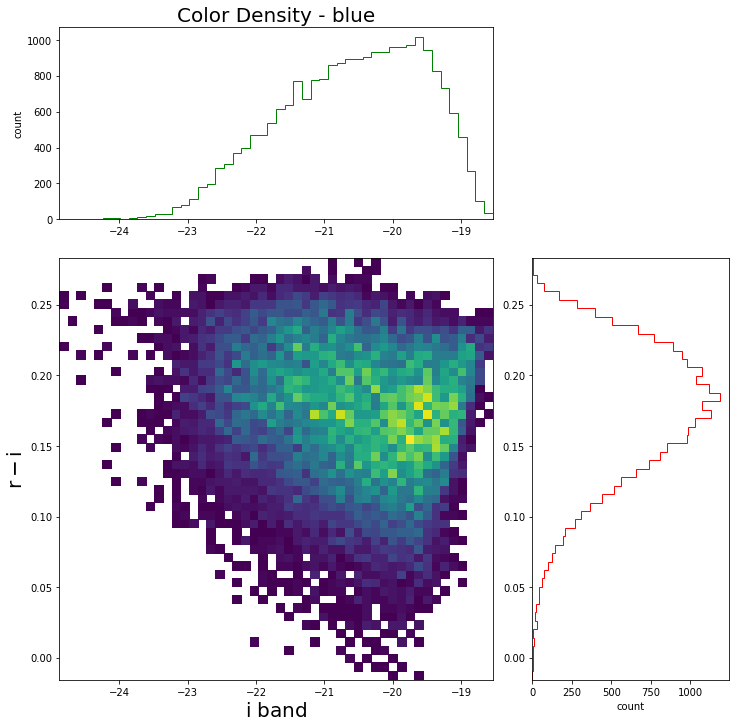

In [19]:
for i in range(0,4):
    mag = sats[i]['SubhaloStellarPhotometrics'][:,5] - sats[i]['SubhaloStellarPhotometrics'][:,6]
    i_band = sats[i]['SubhaloStellarPhotometrics'][:,6]
    property_plotter(i_band, mag, '$\mathrm{i}$ band', "$\mathrm{r-i}$", "Color Density - " + color[i])

## Color-Mass

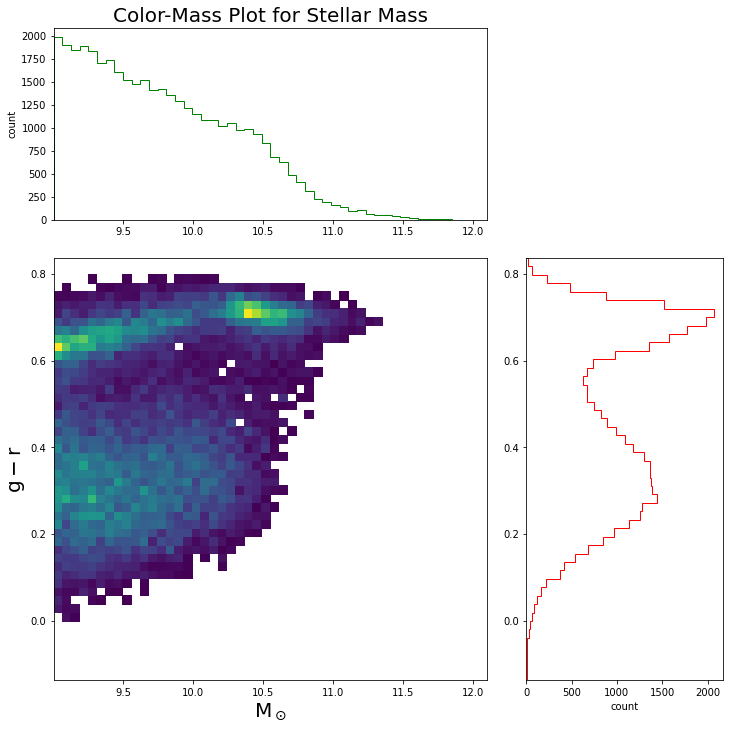

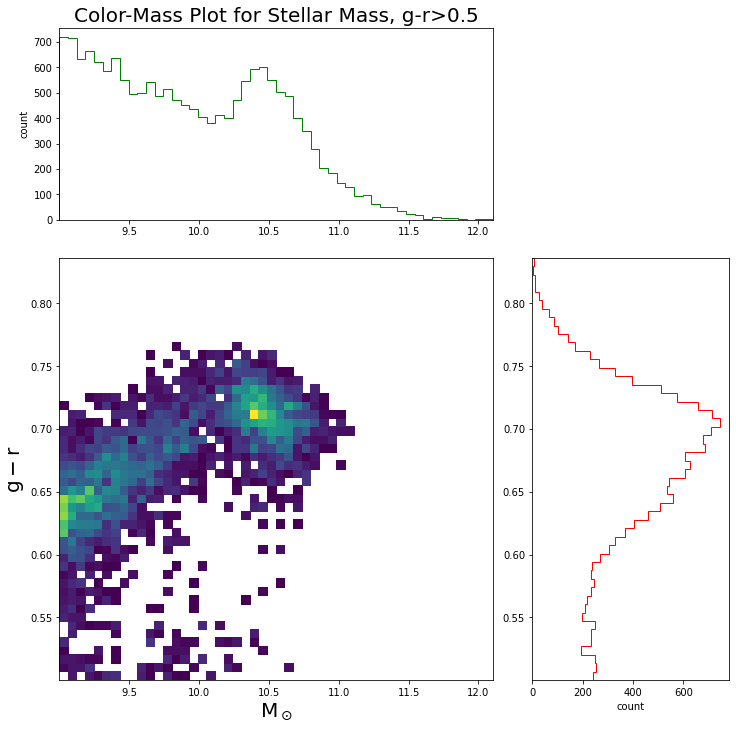

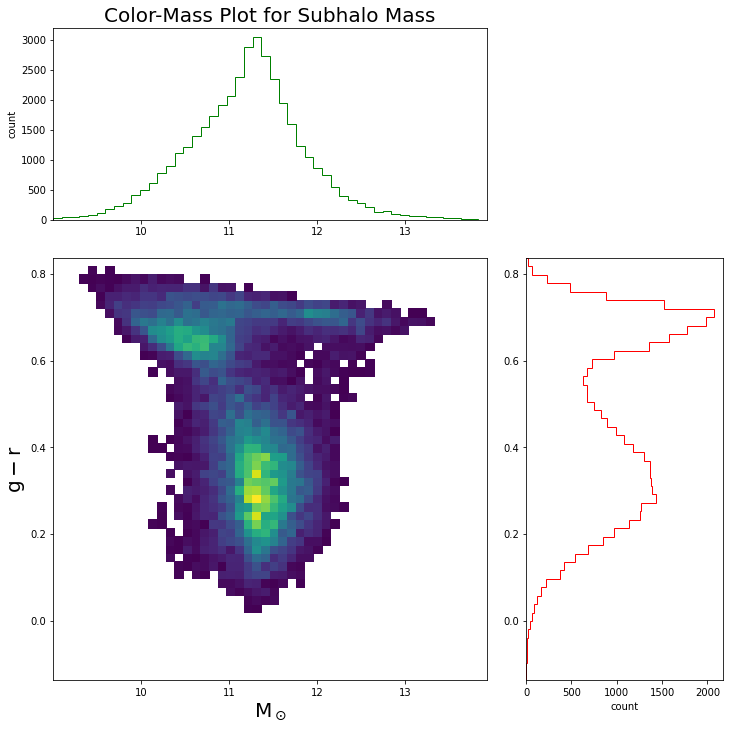

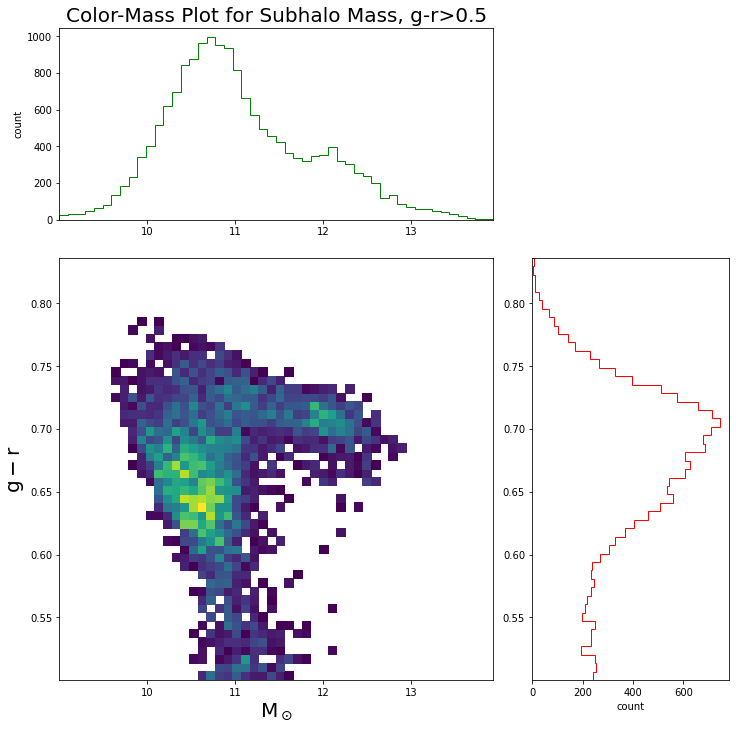

In [20]:
#Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
def mass_vs_gmr(table, table_name, mass_type):
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    mass = np.array(np.log10(table[mass_type]*1e10))
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
    ax_main.hist2d(mass, mag, bins=50, cmap='viridis', cmin=10) #, range=[[9,12], [0,1]])
    ax_main.set_xlabel("$\mathrm{M_\odot}$", fontsize=20)
    ax_main.set_ylabel("$\mathrm{g-r}$", fontsize=20)

    ax_x.hist(mass,bins=50,align='mid', histtype='step', color = 'green')
    ax_x.set(ylabel='count')
    ax_x.set_title(table_name, fontsize = 20)
    ax_y.hist(mag,bins=50,orientation='horizontal',align='mid', histtype='step', color = 'red')
    ax_y.set(xlabel='count')
    plt.show()
    
mass_vs_gmr(satellites, "Color-Mass Plot for Stellar Mass", "StellarMass")
mag = satellites['SubhaloStellarPhotometrics'][:,4] - satellites['SubhaloStellarPhotometrics'][:,5]
mass_vs_gmr(satellites[mag>0.5], "Color-Mass Plot for Stellar Mass, g-r>0.5", "StellarMass")
mass_vs_gmr(satellites, "Color-Mass Plot for Subhalo Mass","SubhaloMass")
mass_vs_gmr(satellites[mag>0.5], "Color-Mass Plot for Subhalo Mass, g-r>0.5", "SubhaloMass")

## Color-Color g-r

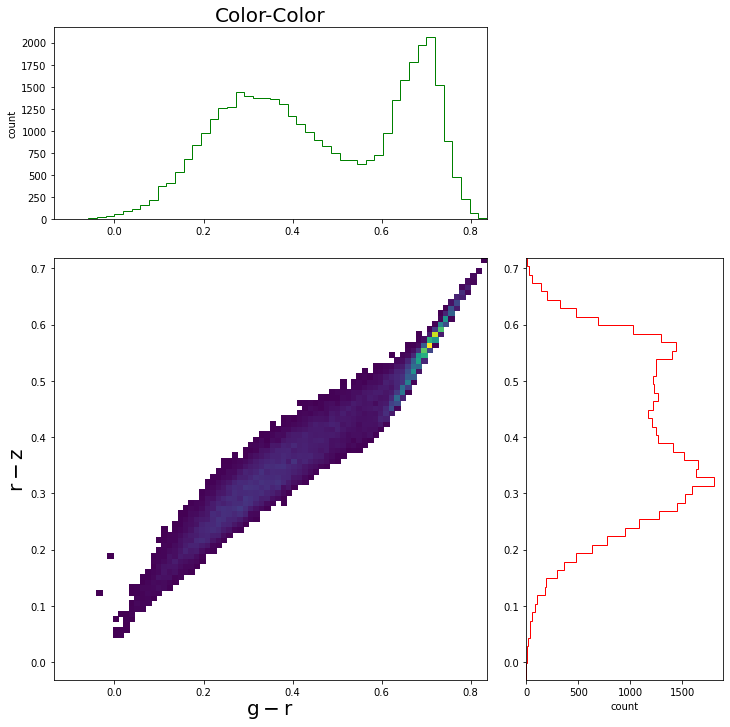

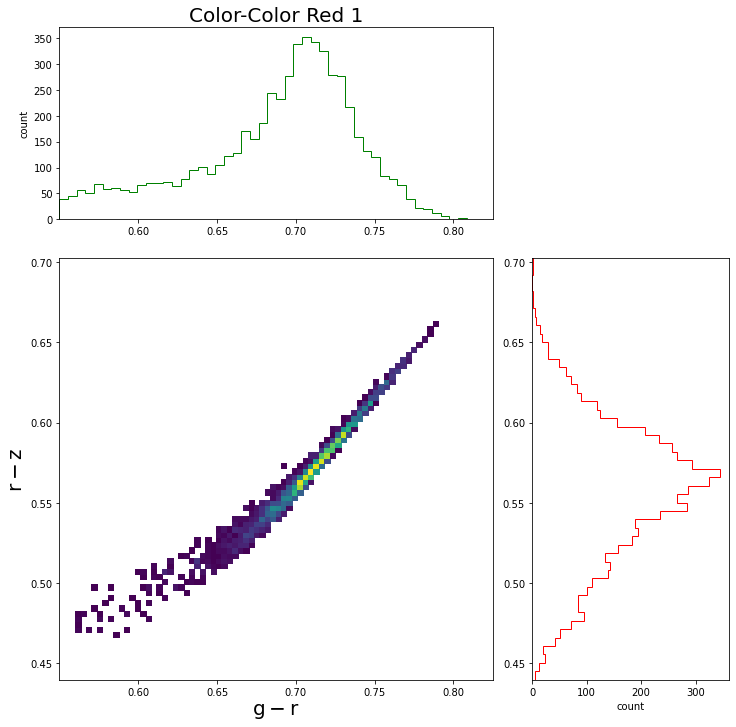

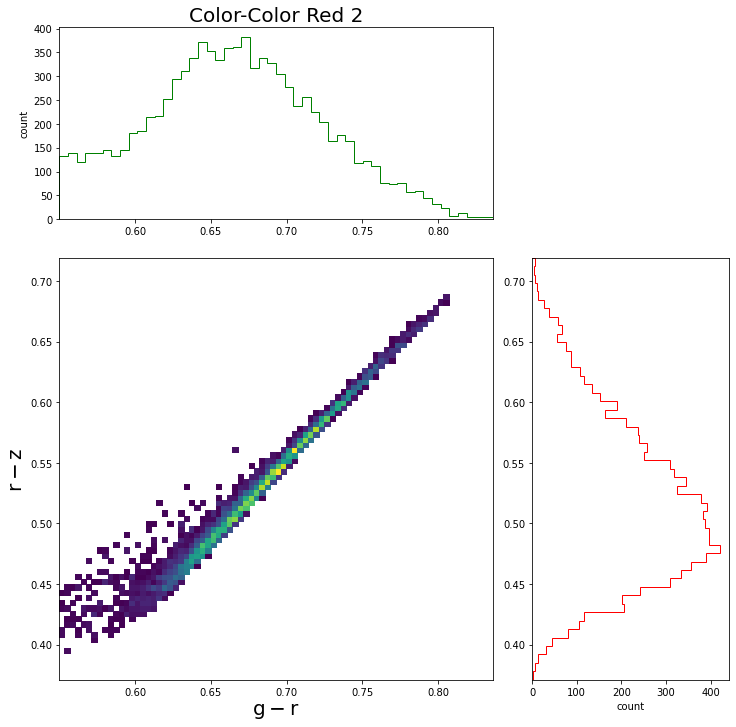

In [44]:
g_minus_r = sats[0]['SubhaloStellarPhotometrics'][:,4]-sats[0]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[0]['SubhaloStellarPhotometrics'][:,5]-sats[0]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color")
g_minus_r = sats[1]['SubhaloStellarPhotometrics'][:,4]-sats[1]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[1]['SubhaloStellarPhotometrics'][:,5]-sats[1]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color Red 1")
g_minus_r = sats[2]['SubhaloStellarPhotometrics'][:,4]-sats[2]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[2]['SubhaloStellarPhotometrics'][:,5]-sats[2]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color Red 2")

## Color-Color r-i

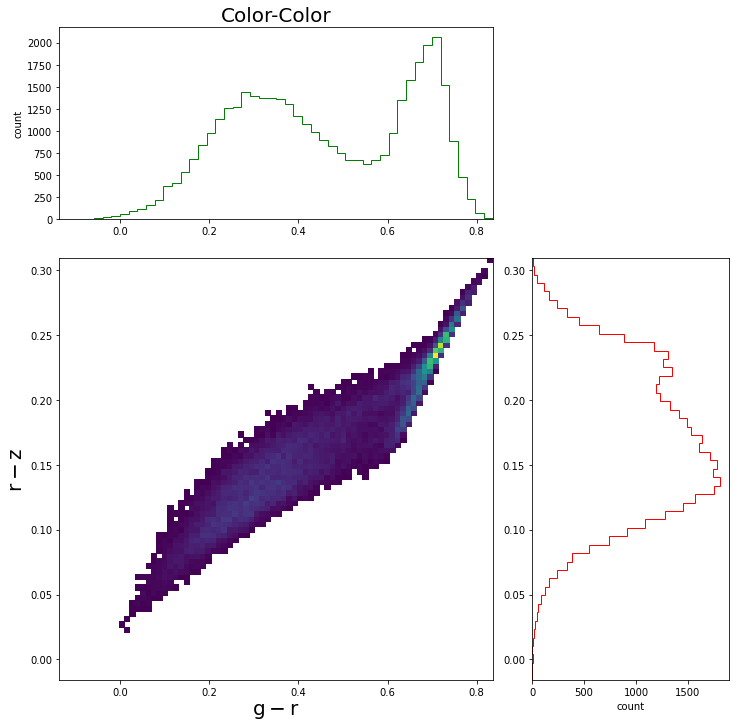

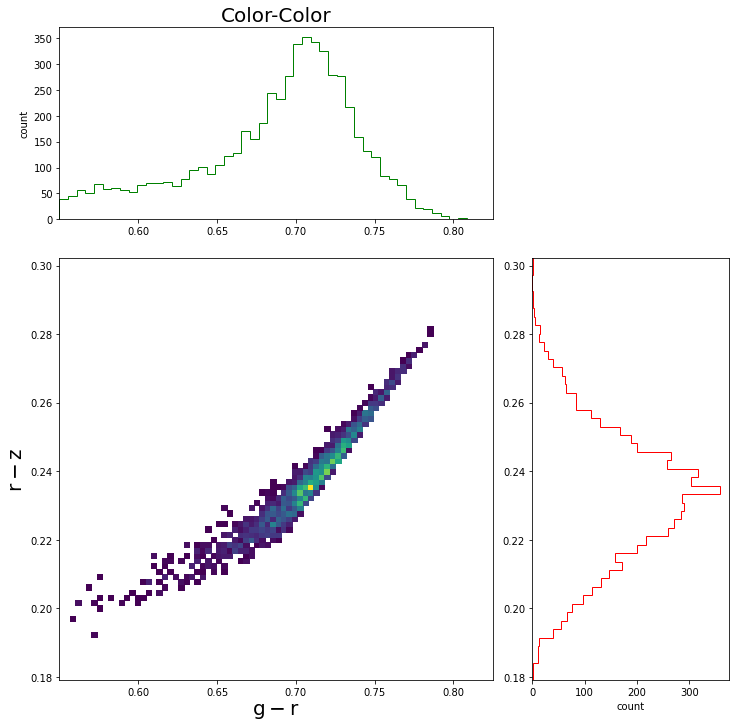

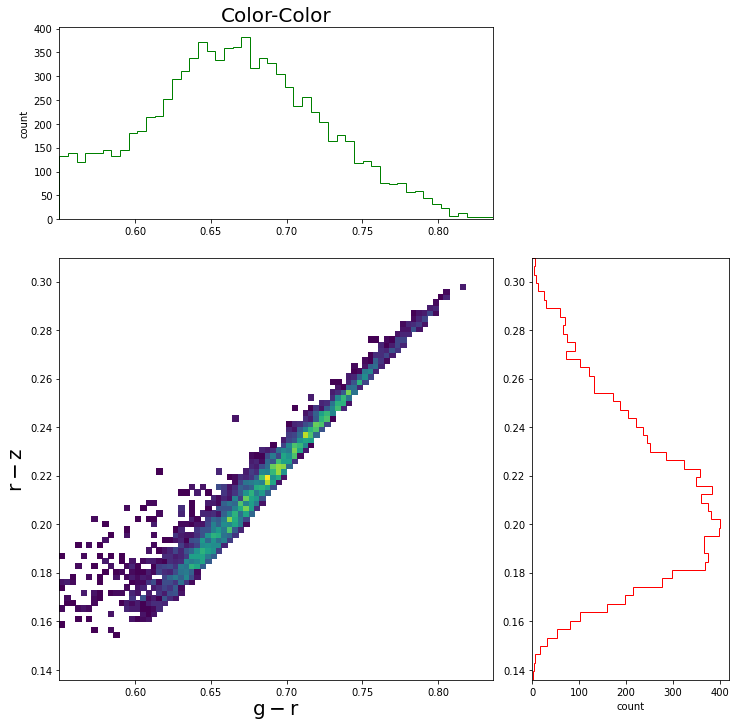

In [46]:
g_minus_r = sats[0]['SubhaloStellarPhotometrics'][:,4]-sats[0]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[0]['SubhaloStellarPhotometrics'][:,6]-sats[0]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color")
g_minus_r = sats[1]['SubhaloStellarPhotometrics'][:,4]-sats[1]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[1]['SubhaloStellarPhotometrics'][:,6]-sats[1]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color")
g_minus_r = sats[2]['SubhaloStellarPhotometrics'][:,4]-sats[2]['SubhaloStellarPhotometrics'][:,5]
r_minus_z = sats[2]['SubhaloStellarPhotometrics'][:,6]-sats[2]['SubhaloStellarPhotometrics'][:,7]
property_plotter(g_minus_r, r_minus_z, "$\mathrm{g-r}$", "$\mathrm{r-z}$", "Color-Color")


## SFR vs. Metal

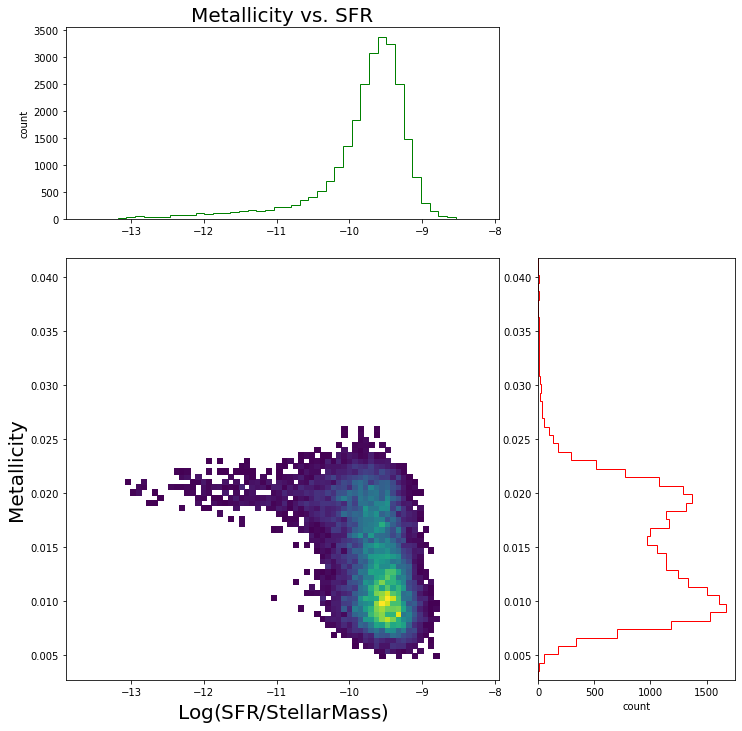

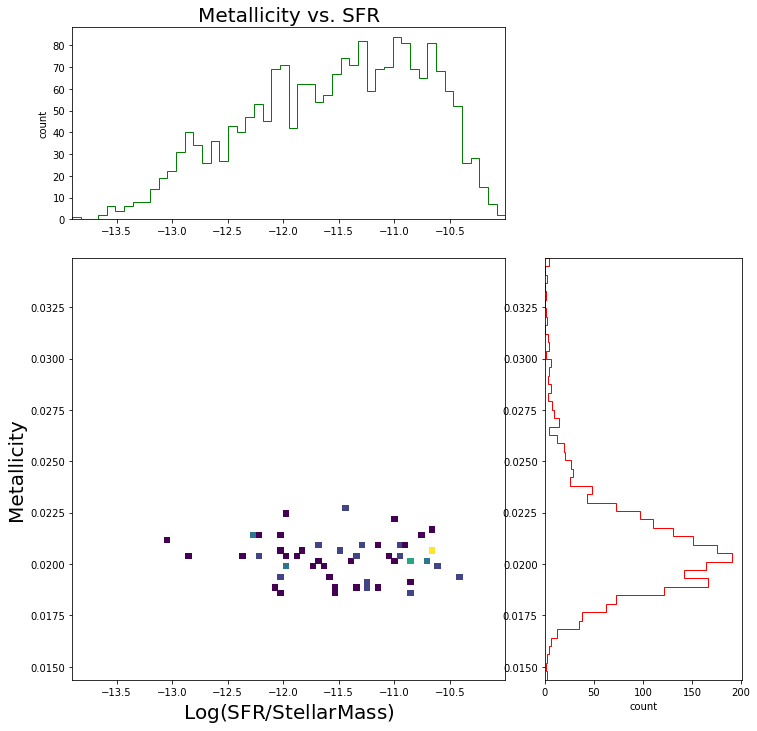

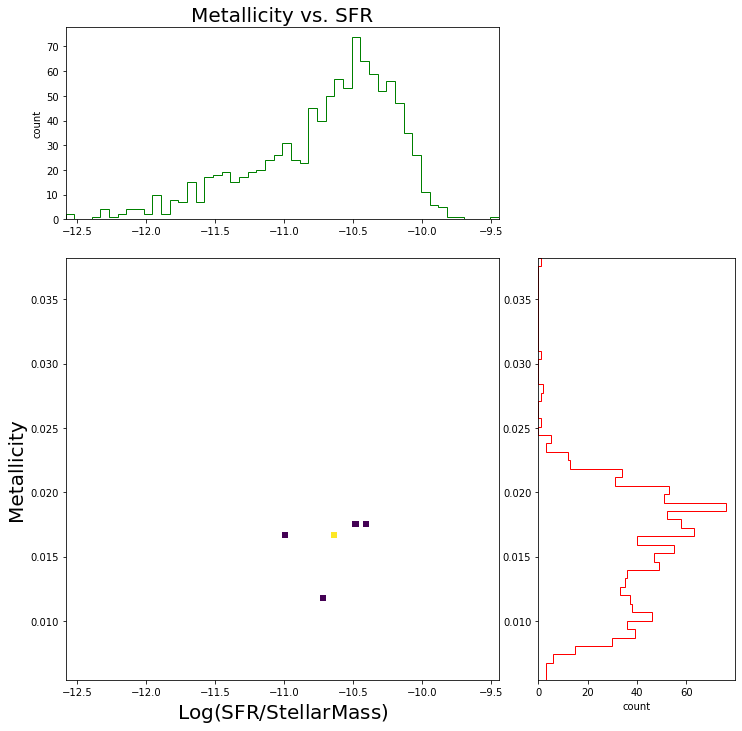

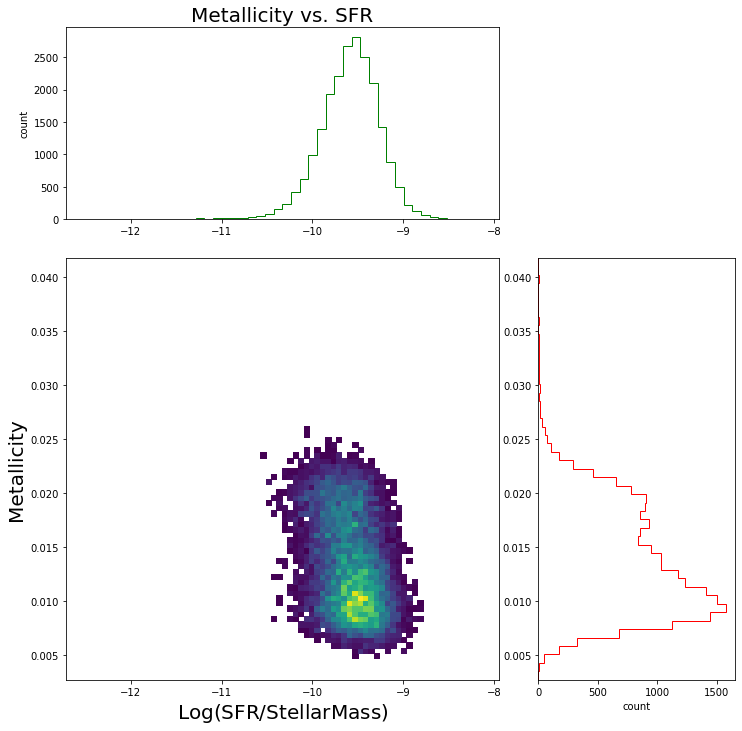

In [21]:
for i in range(0,4):
    sfr_sats = sats[i][sats[i]['SubhaloSFR']!=0]
    sm = np.log10(sfr_sats['StellarMass']*1e10)
    sfr = sfr_sats['SubhaloSFR']
    metallicity = sfr_sats['SubhaloStarMetallicity']
    property_plotter(np.log10(sfr/(10**sm)), metallicity,  "$\mathrm{Log(SFR/StellarMass)}$","Metallicity", "Metallicity vs. SFR")


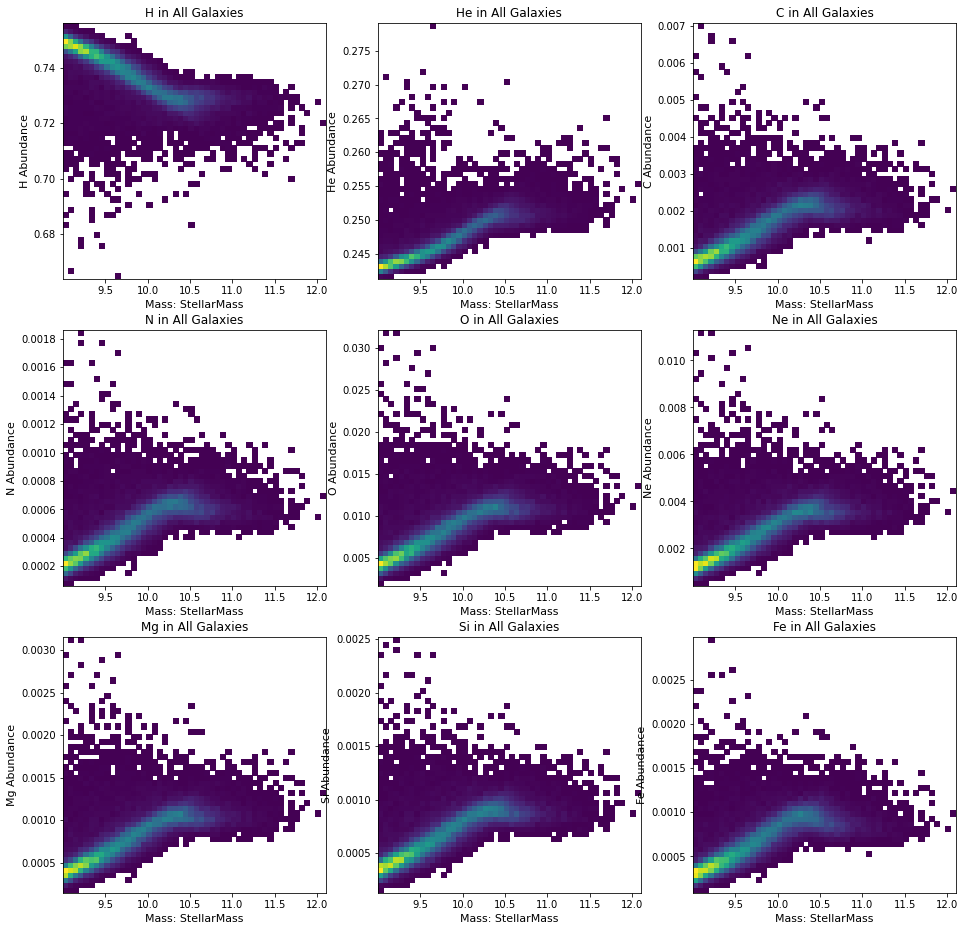

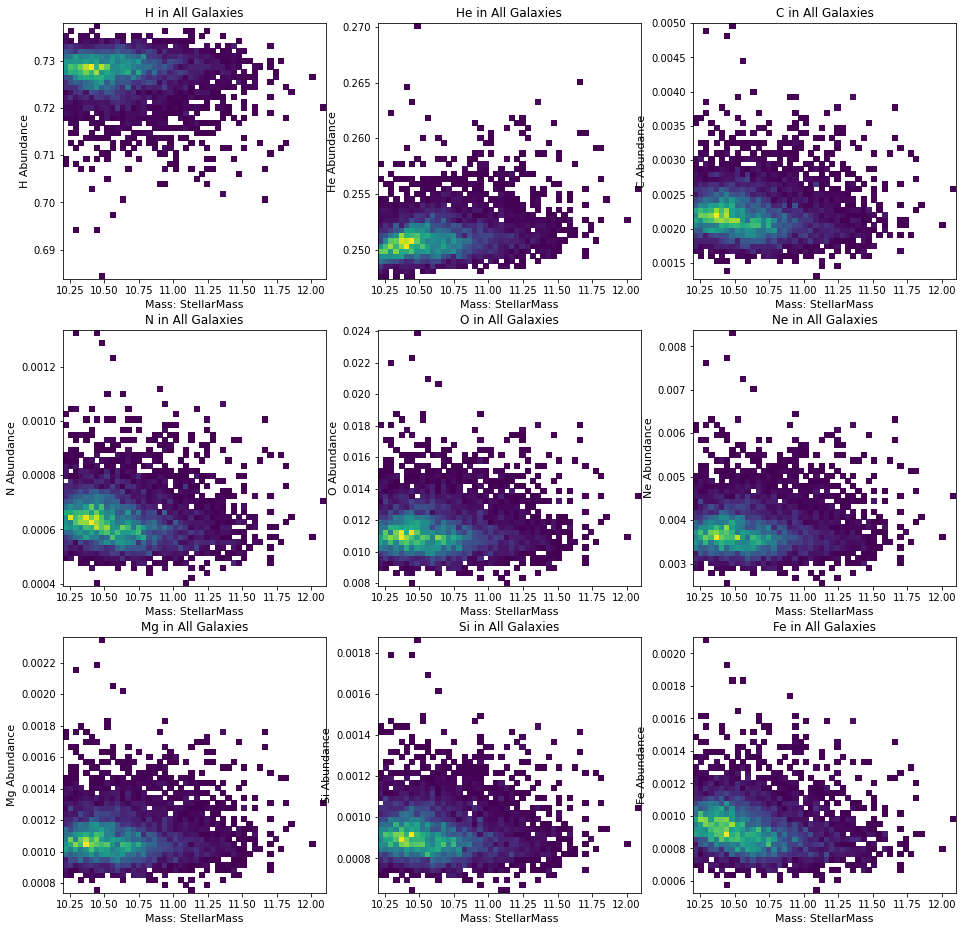

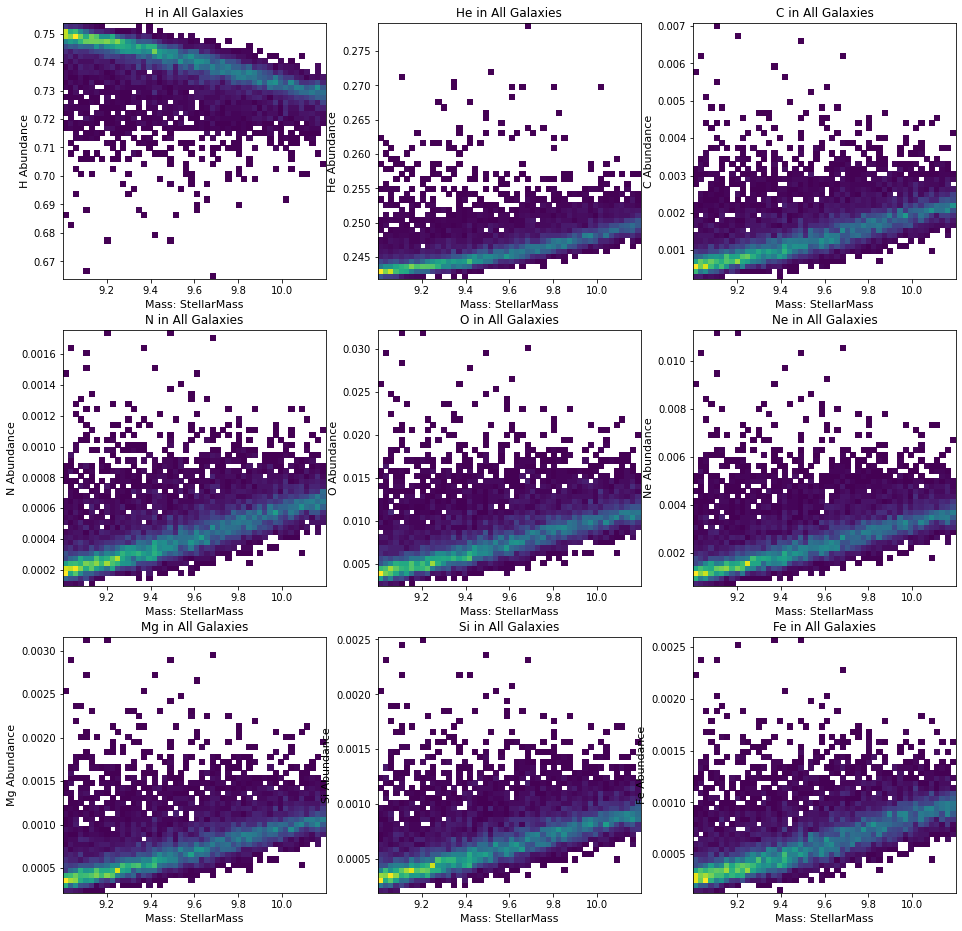

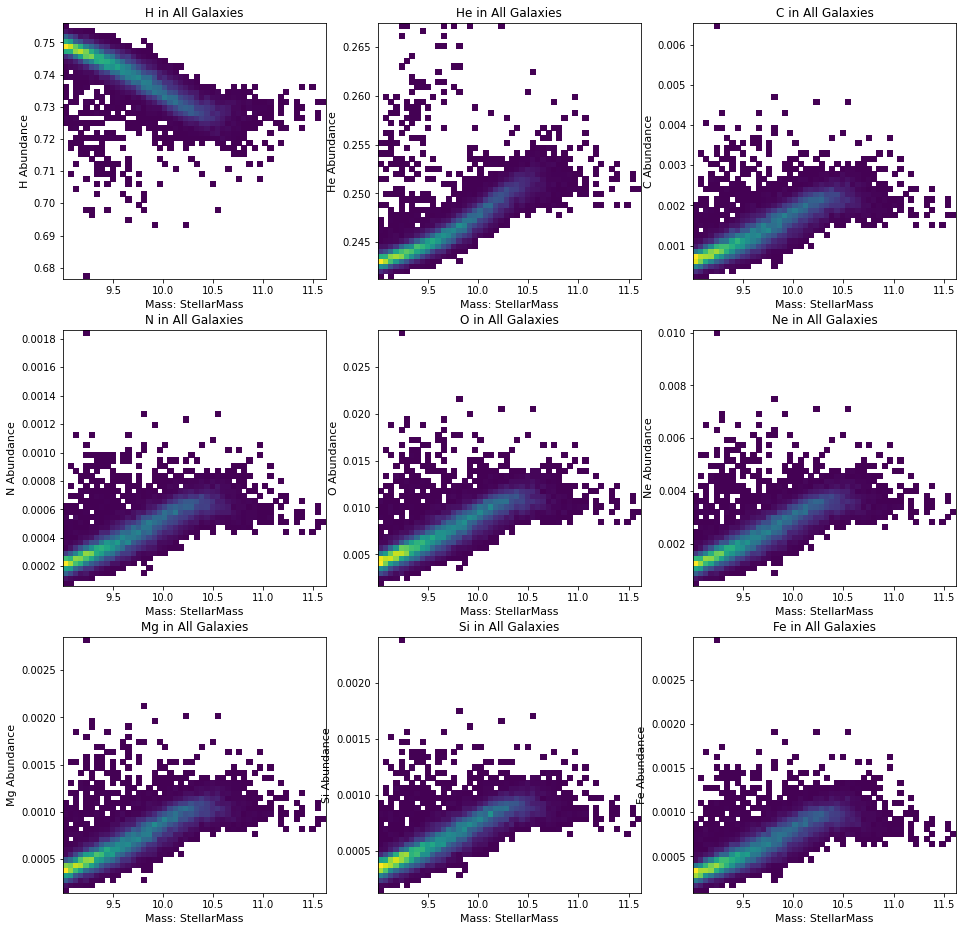

In [16]:
def element_rate_vs_mass(table, table_name, mass_type):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    fig, ax = plt.subplots(3,3)
    fig.set_size_inches(16,16)
    for i in range (0, len(elements)):
        mass = np.array(np.log10(table[mass_type]*1e10))
        ax[i//3][i%3].set_xlabel("Mass: " + str(mass_type), fontsize = 11)
        ax[i//3][i%3].set_ylabel(elements[i] + " Abundance", fontsize = 11)
        ax[i//3][i%3].set_title(elements[i] + " in " + table_name, fontsize=12)
        ax[i//3][i%3].hist2d(mass, table['SubhaloStarMetalFractions'][:,i], bins=50, cmap='viridis', cmin=0.1)
        
element_rate_vs_mass(sats[0], "All Galaxies", "StellarMass")
element_rate_vs_mass(sats[1], "RED1 Galaxies", "StellarMass")
element_rate_vs_mass(sats[2], "RED2 Galaxies", "StellarMass")
element_rate_vs_mass(sats[3], "BLUE Galaxies", "StellarMass")

# Dark Matter Ratio

In [23]:
def mass_ratio_vs_gmr(table, table_name, mass_type, lb, ub, bhole):
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    mass_ratio = table['SubhaloMassType'][:,mass_type]/table['SubhaloMass']#np.array(np.log10(table[mass_type]*1e10))
    original_num = len(mass_ratio)
    
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
    ax_main.set_xlabel("Proportion of Dark Matter to Total Matter", fontsize=20)
    ax_main.set_ylabel("$\mathrm{g-r}$", fontsize=20)

    if(bhole):
        mask = mass_ratio>0
        mass_ratio = mass_ratio[mask]
        mag = mag[mask]
        ax_main.hist2d(mass_ratio, mag, bins=70, cmap='viridis', cmin=5,range=[[0,0.001],[lb,ub]])
        print("Proportion of subhalos without any black hole mass: "+ str(1 - len(mass_ratio)/original_num))
    else:
        ax_main.hist2d(mass_ratio, mag, bins=70, cmap='viridis', cmin=5,range=[[0,1],[lb,ub]])
        
    ax_x.hist(mass_ratio,bins=50,align='mid', histtype='step', color = 'green')
    ax_x.set(ylabel='count')
    ax_x.set_title(table_name, fontsize = 20)
    ax_y.hist(mag,bins=50,orientation='horizontal',align='mid', histtype='step', color = 'red')
    ax_y.set(xlabel='count')
    plt.show()
    
def mass_ratio_vs_radius(table, table_name, mass_type, lb, ub, bhole):
    mass_ratio = table['SubhaloMassType'][:,mass_type]/table['SubhaloMass']
    original_num = len(mass_ratio)
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
    
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)
    ax_main.set_xlabel("Proportion of Dark Matter to Total Matter", fontsize = 16)
    ax_main.set_ylabel("Radius in Mpc/h", fontsize = 16)
    ax_x.set_title(table_name, fontsize = 20)
    
    if(bhole):
        mask = mass_ratio>0
        mass_ratio = mass_ratio[mask]
        mag = mag[mask]
        ax_main.hist2d(mass_ratio,r_subhalo, bins=70, cmap='viridis', cmin=5, range=[[lb,ub],[0,8]])
        print("Proportion of subhalos without any black hole mass: "+ str(1 - len(mass_ratio)/original_num))
    else:
        ax_main.hist2d(mass_ratio, r_subhalo, bins=70, cmap='viridis', cmin=5, range=[[lb,ub],[0,8]])
        
    ax_x.hist(mass_ratio,bins=50,align='mid', histtype='step', color = 'green')
    ax_x.set(ylabel='count')
    ax_y.hist(r_subhalo,bins=50,orientation='horizontal',align='mid', histtype='step', color = 'red')
    ax_y.set(xlabel='count')
    plt.show()

def sfr_vs_mass_ratio(table, table_name, mass_type):
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    #table = table[mag<0.55] #mag cut 
    mass_ratio = table['SubhaloMassType'][:,mass_type]/table['SubhaloMass']
    
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)
    ax_main.set_xlabel("Mass Ratio", fontsize = 16)
    ax_main.set_ylabel("Stellar Formation Rate: Msun/yr", fontsize = 16)
    ax_x.set_title(table_name, fontsize = 20)
    sfr = table['SubhaloSFR']
    ax_main.hist2d(mass_ratio, sfr, bins=70, cmap='viridis', cmin=5,range=[[0,1],[0,5]])#, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,10]])
    plt.show()
    
    
def sfr_log_vs_mass_ratio(table, table_name, mass_type, vmax):
    table = table[table['SubhaloSFR']>0]
    sfr = table['SubhaloSFR']
    sm = np.log10(table['StellarMass']*1e10)
    #table = table[mag<0.55] #mag cut 
    mass_ratio = table['SubhaloMassType'][:,mass_type]/table['SubhaloMass']
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_x = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_y = plt.subplot(gs[1:3, 2],sharey=ax_main)
    sfr = table['SubhaloSFR']
    
    ax_main.set_ylabel("$\mathrm{Log(SFR/StellarMass)}$", fontsize = 14)
    ax_main.set_title(table_name, fontsize=16)
    
    if(vmax):
        mass_ratio = table['SubhaloVmax']
        ax_main.set_xlabel("Vmax", fontsize = 14)
    else:
        ax_main.set_xlabel("Mass Ratio", fontsize = 14)
    #table['SubhaloVmax']
    ax_main.hist2d(mass_ratio, np.log10(sfr/(10**sm)), bins=40, cmap='viridis', cmin=5)#,range=[[0,1],[0,5]])#, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,10]])
    ax_x.hist(mass_ratio,bins=50,align='mid', histtype='step', color = 'green')
    ax_x.set(ylabel='count')
    ax_y.hist(np.log10(sfr/(10**sm)),bins=50,orientation='horizontal',align='mid', histtype='step', color = 'red')
    ax_y.set(xlabel='count')
    plt.show()
    
def mass_ratio_vs_gmr_radially_binned(table, table_name, mass_type, lb, ub, bhole, bins):
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(22,13)
    
    
    for i in range(0, len(bins)-1):
        boxsize = header['BoxSize'] #kpc/h
        box_bounds = boxsize*np.ones(3)#*conv_fac
        dev = table['SubhaloPos']-table['GroupPos']

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
        r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
        
        table_select = table[r_subhalo < bins[i+1]]
        r_subhalo = r_subhalo[r_subhalo < bins[i+1]]
        table_select = table_select[r_subhalo > bins[i]]
        
        mag = table_select['SubhaloStellarPhotometrics'][:,4] - table_select['SubhaloStellarPhotometrics'][:,5]
        mass_ratio = table_select['SubhaloMassType'][:,mass_type]/table_select['SubhaloMass']#np.array(np.log10(table[mass_type]*1e10))

        ax[i//3][i%3].set_ylabel("$\mathrm{g-r}$", fontsize = 16)
        ax[i//3][i%3].set_xlabel("Mass Ratio", fontsize = 16)
        ax[i//3][i%3].set_title("Color-DM Ratio, "+table_name+", radial bins: ["+str(bins[i])+","+str(bins[i+1])+"] Mpc/h", fontsize = 16)
        if(bhole):
            ax[i//3][i%3].hist2d(mass_ratio, mag, bins=50, cmap='viridis', cmin=1,range=[[0,0.0015],[lb,ub]])
        else:
            ax[i//3][i%3].hist2d(mass_ratio, mag, bins=50, cmap='viridis', cmin=1,range=[[0,1],[lb,ub]])

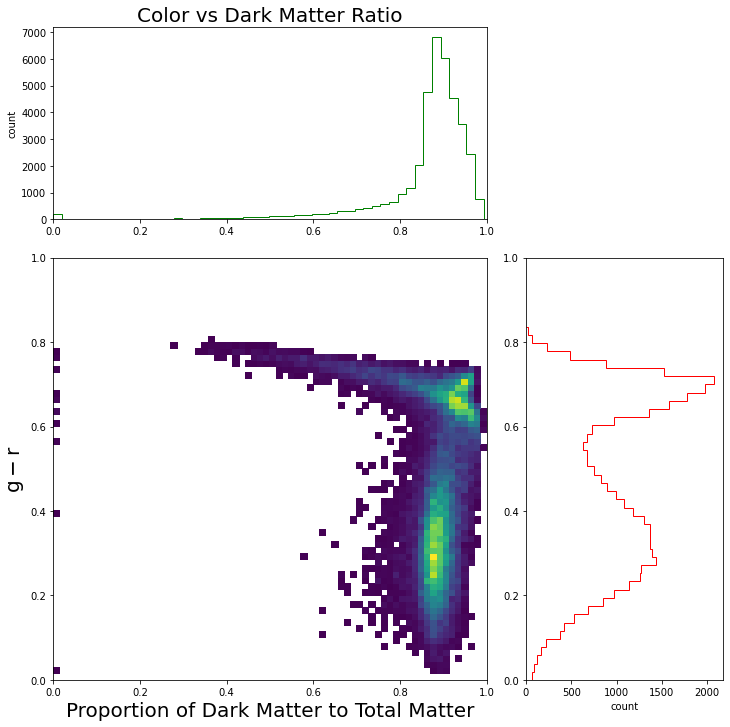

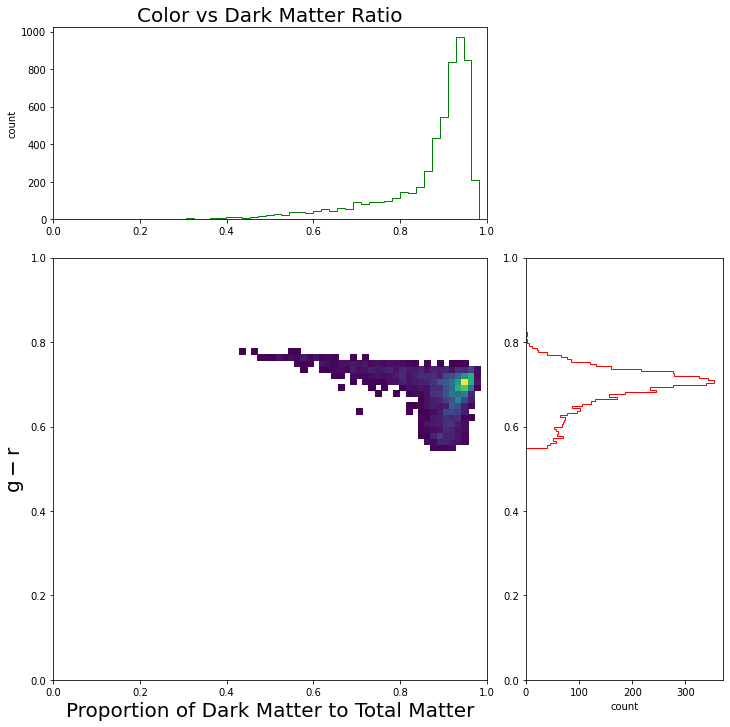

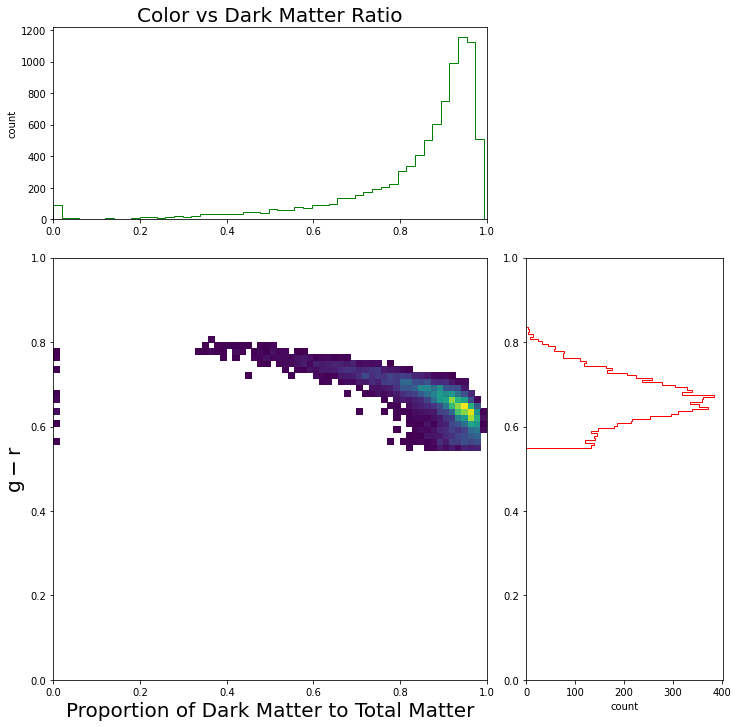

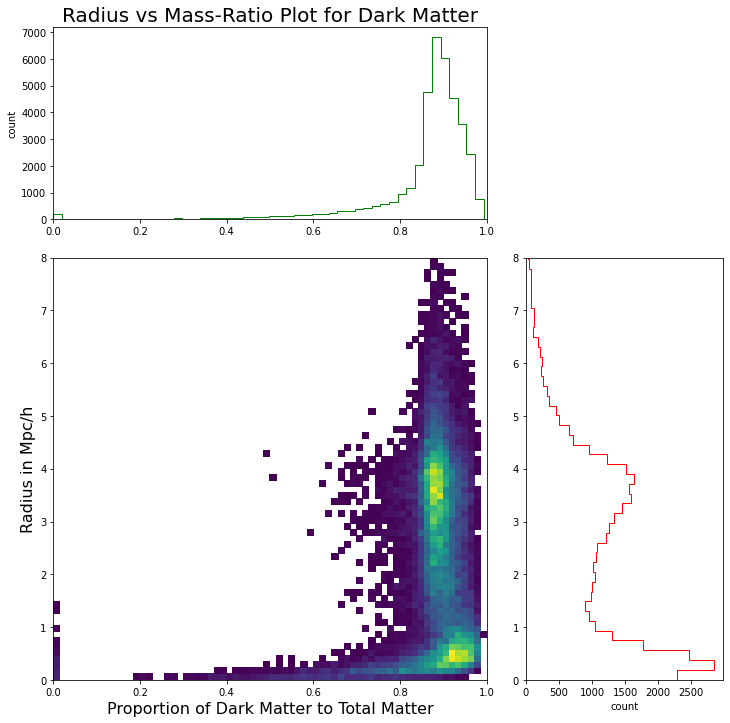

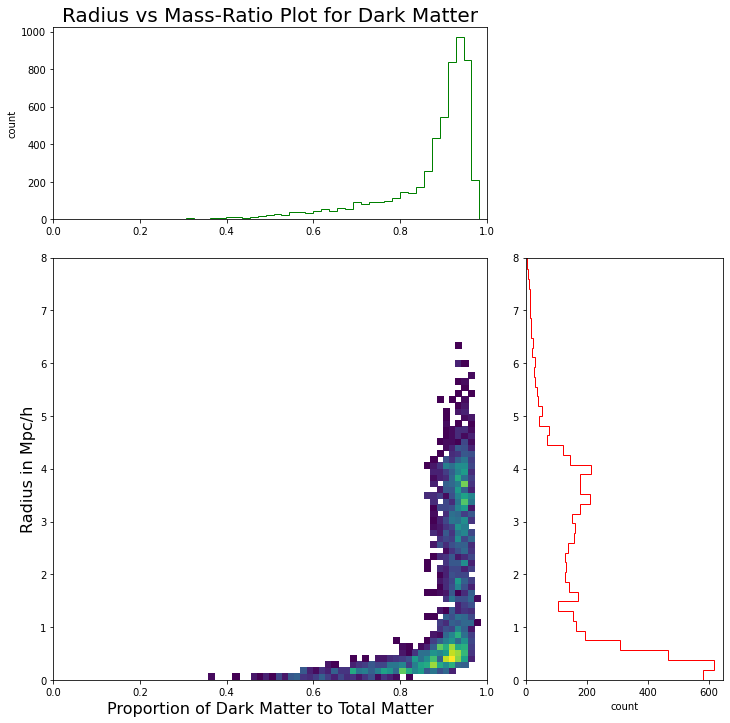

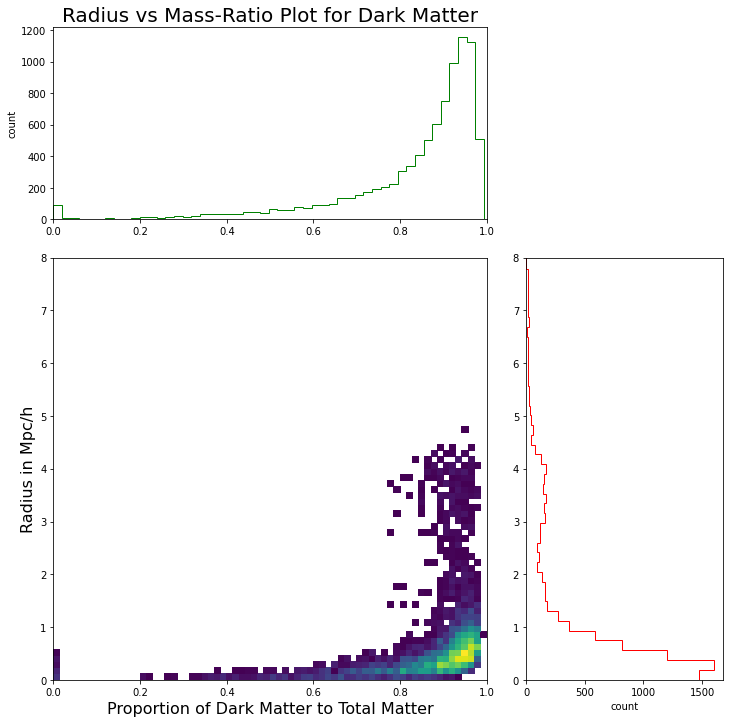

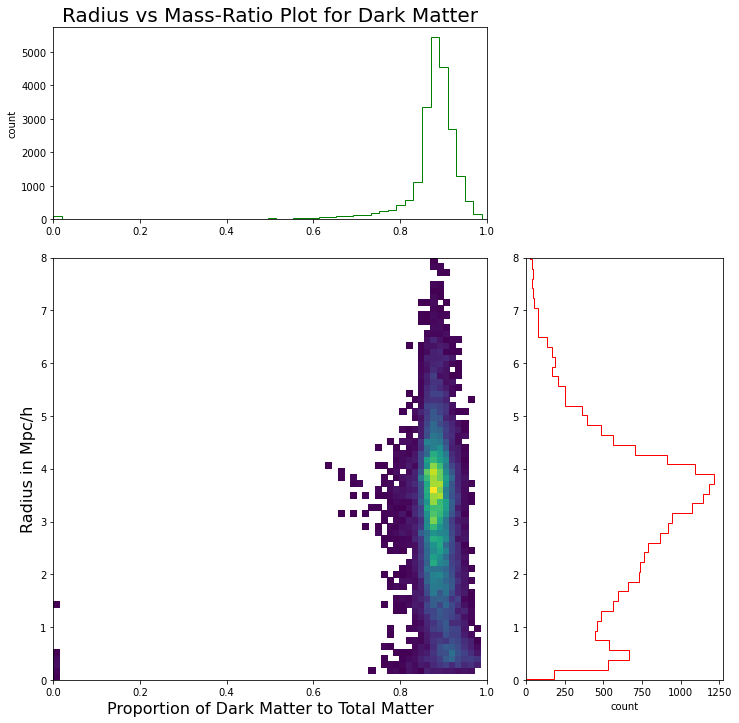

In [26]:
mass_ratio_vs_gmr(satellites, "Color vs Dark Matter Ratio", 1, 0, 1, False)
mass_ratio_vs_gmr(satellites_red, "Color vs Dark Matter Ratio", 1, 0, 1, False)
mass_ratio_vs_gmr(satellites_green, "Color vs Dark Matter Ratio", 1, 0, 1, False)
mass_ratio_vs_radius(satellites, "Radius vs Mass-Ratio Plot for Dark Matter", 1, 0, 1, False)
mass_ratio_vs_radius(satellites_red, "Radius vs Mass-Ratio Plot for Dark Matter", 1, 0, 1, False)
mass_ratio_vs_radius(satellites_green, "Radius vs Mass-Ratio Plot for Dark Matter", 1, 0, 1, False)
mass_ratio_vs_radius(satellites_blue, "Radius vs Mass-Ratio Plot for Dark Matter", 1, 0, 1, False)

#sfr_vs_mass_ratio(satellites, "SFR vs Mass-Ratio Plot for Dark Matter", 1)


### SFR PLOTS

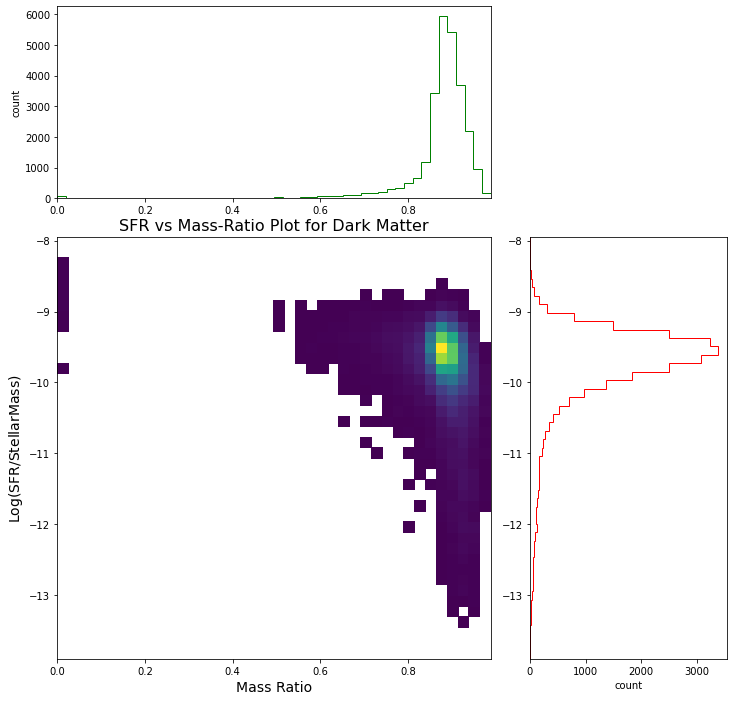

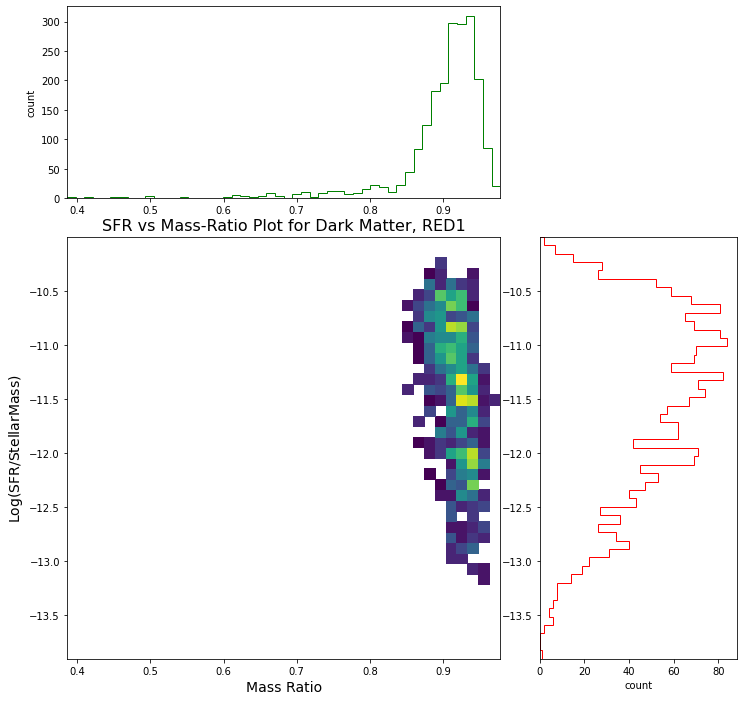

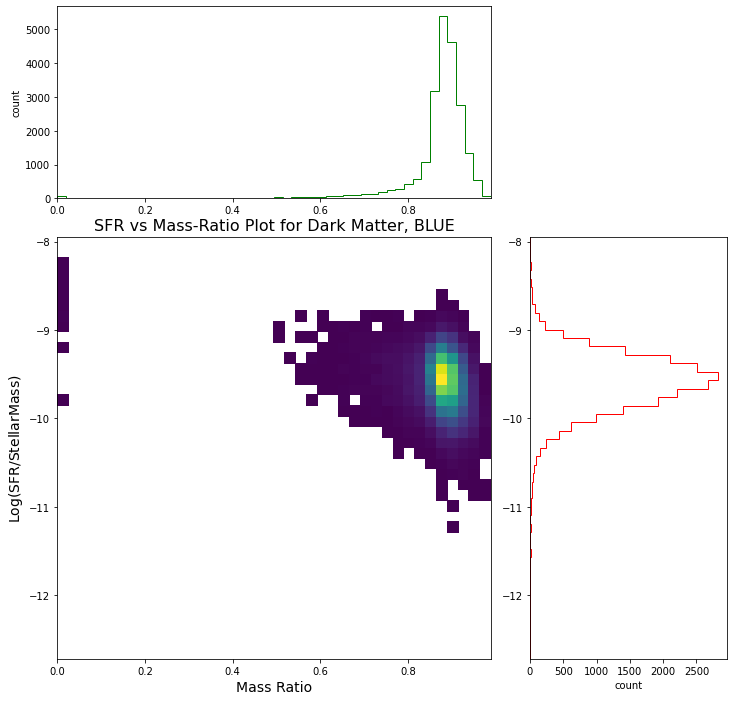

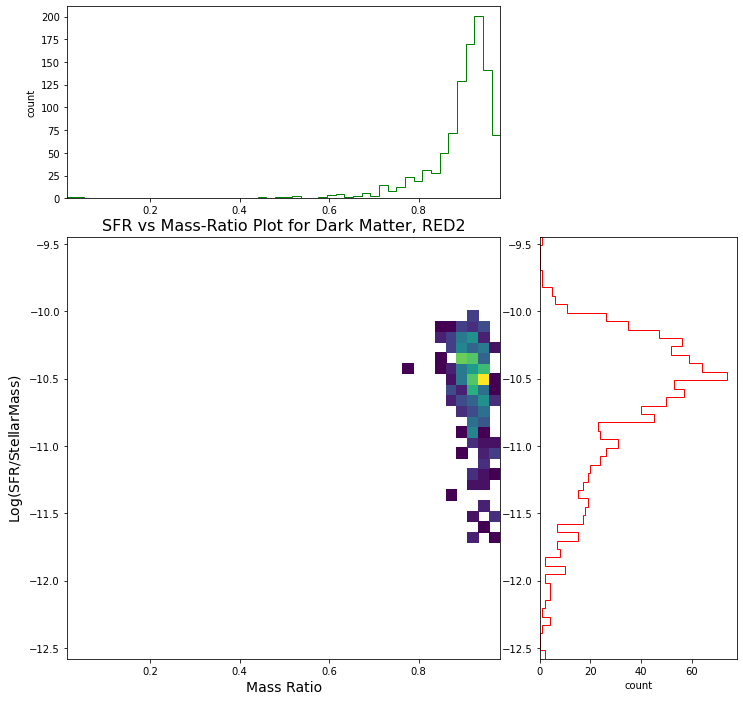

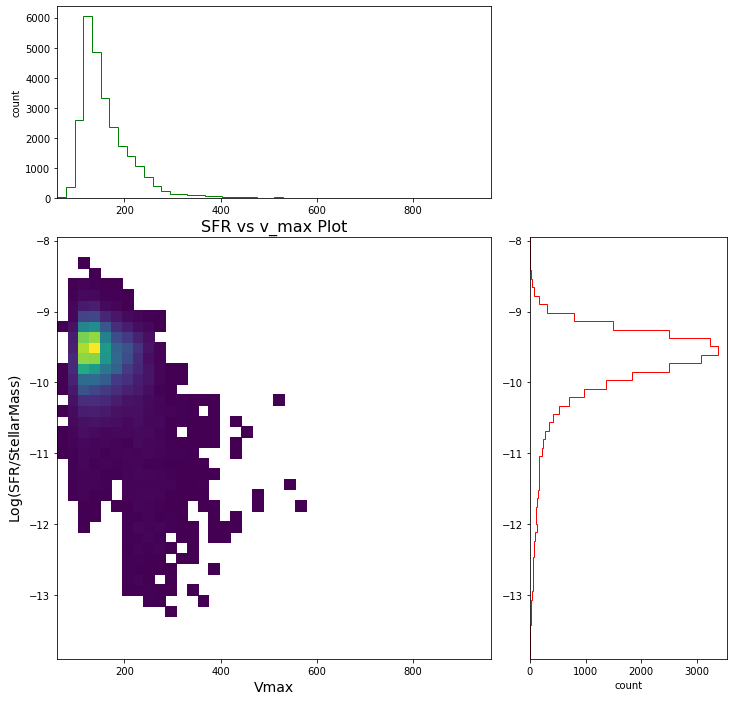

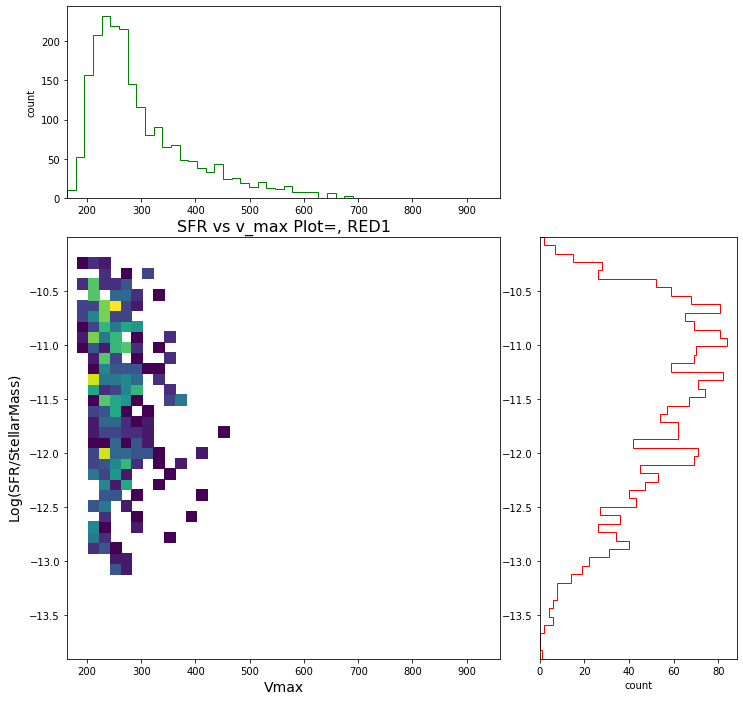

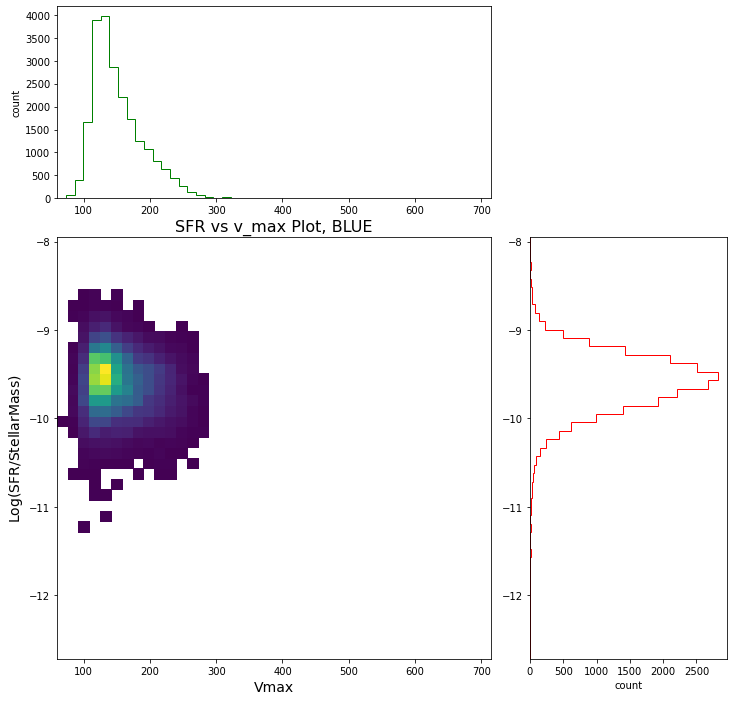

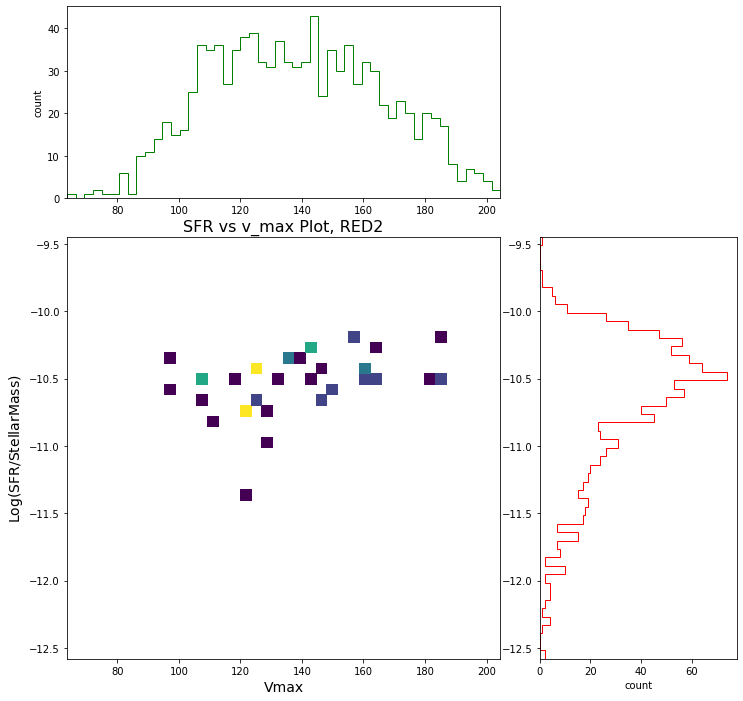

In [39]:
sfr_log_vs_mass_ratio(satellites, "SFR vs Mass-Ratio Plot for Dark Matter", 1, False)
sfr_log_vs_mass_ratio(satellites_red, "SFR vs Mass-Ratio Plot for Dark Matter, RED1", 1, False)
sfr_log_vs_mass_ratio(satellites_blue, "SFR vs Mass-Ratio Plot for Dark Matter, BLUE", 1, False)
sfr_log_vs_mass_ratio(satellites_green, "SFR vs Mass-Ratio Plot for Dark Matter, RED2", 1, False)

sfr_log_vs_mass_ratio(satellites, "SFR vs v_max Plot", 1, True)
sfr_log_vs_mass_ratio(satellites_red, "SFR vs v_max Plot=, RED1", 1, True)
sfr_log_vs_mass_ratio(satellites_blue, "SFR vs v_max Plot, BLUE", 1, True)
sfr_log_vs_mass_ratio(satellites_green, "SFR vs v_max Plot, RED2", 1, True)

In [ ]:
bins=[0,1,2,3,4,5,10]
mass_ratio_vs_gmr_radially_binned(satellites_blue, "Blue", 1, 0.0,0.55, False, bins)
bins=[0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8]
mass_ratio_vs_gmr_radially_binned(satellites_green, "Red2", 1, 0.5, 0.85, False, bins)

In [ ]:
bins=[0,1,2,3,4,5,10]
mass_ratio_vs_gmr_radially_binned(satellites_red, "Red1", 1, 0.5, 0.85, False, bins)

### Black Hole

In [ ]:
mass_ratio_vs_gmr(satellites_red, "Color-Black Hole Mass Ratio, RED, removed 0", 5, 0.5, 0.85, True)

mass_ratio_vs_gmr(satellites_green, "Color-Black Hole Mass Ratio, RED2, removed 0", 5, 0.5, 0.85, True)

mass_ratio_vs_gmr(satellites_blue, "Color-Black Hole Mass Ratio, BLUE, removed 0", 5, 0, 0.5, True)

print(len(satellites_red[satellites_red['SubhaloBHMass']==0]))
print(len(satellites_green[satellites_green['SubhaloBHMass']==0]))
print(len(satellites_blue[satellites_blue['SubhaloBHMass']==0]))

In [ ]:
#Satellite galaxies red1: 5695
#Satellite galaxies red2: 9074
#Satellite galaxies blue: 21999

## Phase Space

In [23]:
def phase_space(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    dev = dev/(np.linalg.norm(dev, axis=1).reshape(-1,1))
    v_rad = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        v_rad[i]= np.dot(v[i],dev[i])

    plt.figure(figsize=(8,6))
    plt.scatter(r_subhalo,v_rad, s=0.2)
    plt.title("Phase Space " + color + " " + table_name , fontsize=14)
    plt.ylabel("Radial velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()
    
def tangential_v1(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    dev = dev
    v_tan = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        cross_prod = np.cross(v[i],dev[i])
        norm_cross = np.linalg.norm(cross_prod)
        v_tan[i]= norm_cross/(np.linalg.norm(dev[i]))

    plt.figure(figsize=(8,6))
    plt.scatter(r_subhalo,v_tan, s=0.2)
    plt.title("Phase Space " + color + " " + table_name , fontsize=14)
    plt.ylabel("Tangential velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()
    
def tangential_v_radial(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    dev = dev
    v_tan = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        cross_prod = np.cross(v[i],dev[i])
        norm_cross = np.linalg.norm(cross_prod)
        v_tan[i]= norm_cross/(np.linalg.norm(dev[i]))
        
    dev = dev/(np.linalg.norm(dev, axis=1).reshape(-1,1))
    v_rad = np.empty([len(dev)])
    
    for i in range(0, len(dev)):
        v_rad[i]= np.dot(v[i],dev[i])

    plt.figure(figsize=(8,6))
    plt.scatter(v_rad,v_tan, s=0.2)
    plt.title("Radial vs. Tangential velocity " + color + " " + table_name , fontsize=14)
    plt.ylabel("Tangential velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radial velocity of the subhalo. (km/s)", fontsize=14)
    plt.colorbar()
    plt.show()

def cent_acc_vs_rad(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloPos']-table['GroupPos']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc
    dev = np.linalg.norm(dev, axis=1)
    v_sq = (np.linalg.norm(v, axis=1))**2
    rad_acc = v_sq/dev
    plt.figure(figsize=(8,6))
    plt.scatter(r_subhalo,rad_acc,s=1) #bins=30, cmap='viridis', cmin=0.1, range=[[0,8],[0,2000]])
    plt.title("Acceleration vs. radius " + color + " " + table_name , fontsize=14)
    plt.ylabel("Radial acceleration of the subhalo. (km/s)", fontsize=14)
    plt.xlabel("Radius (Mpc/h)", fontsize=14)
    plt.colorbar()
    plt.show()
    
#Phase Space, color bins
def phase_space_color_bins(galaxies, color, mass_type,bins):
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(22,13)
    for i in range(0,5):
        table = cut_color_lines(galaxies, bins[i], bins[i+1])
        #print(len(table))
        v=table['SubhaloVel']-table['GroupVel']/scale_factor
        boxsize = header['BoxSize'] #kpc/h
        box_bounds = boxsize*np.ones(3)#*conv_fac
        dev = table['SubhaloPos']-table['GroupPos']

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q

        r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
        dev = dev/(np.linalg.norm(dev, axis=1).reshape(-1,1))
        v_rad = np.empty([len(dev)])

        for j in range(0, len(dev)):
            v_rad[j]= np.dot(v[j],dev[j])

        ax[i//3][i%3].hist2d(r_subhalo,v_rad,bins=40, cmin=2, range=[[0,6.5], [-2000, 1500]])
        ax[i//3][i%3].set_title("Phase Space " + color + " G-R Bin: "+str(bins[i])+"-"+str(bins[i+1]) , fontsize=14)
        ax[i//3][i%3].set_ylabel("Radial velocity of the subhalo. (km/s)", fontsize=14)
        ax[i//3][i%3].set_xlabel("Radius (Mpc/h)", fontsize=14)
        #plt.colorbar()
        
def phase_space_mass_bins(galaxies, color, mass_type, bins):
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(22,13)
    for i in range(0,6):
        s1 = cut_mass_high(galaxies, mass_type, bins[i])
        s2 = cut_mass_low(galaxies, mass_type, bins[i+1])
        mask2 = np.array(np.log10(s1[mass_type]*1e10)) < bins[i+1]
        table = s1[mask2]
        #print(len(table))
        v=table['SubhaloVel']-table['GroupVel']/scale_factor
        boxsize = header['BoxSize'] #kpc/h
        box_bounds = boxsize*np.ones(3)#*conv_fac
        dev = table['SubhaloPos']-table['GroupPos']

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q

        r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
        dev = dev/(np.linalg.norm(dev, axis=1).reshape(-1,1))
        v_rad = np.empty([len(dev)])

        for j in range(0, len(dev)):
            v_rad[j]= np.dot(v[j],dev[j])

        ax[i//3][i%3].hist2d(r_subhalo,v_rad,bins=40, cmin=2, range=[[0,6.5], [-2000, 1500]])
        ax[i//3][i%3].set_title("Phase Space " + color + " Mass Bin: "+str(bins[i])+"-"+str(bins[i+1]) , fontsize=14)
        ax[i//3][i%3].set_ylabel("Radial velocity of the subhalo. (km/s)", fontsize=14)
        ax[i//3][i%3].set_xlabel("Radius (Mpc/h)", fontsize=14)
        #plt.colorbar()

### Distance Histogram

(5695,)
Mean distance of red galaxies from halo center in Mpc/h: 2.1575158
Number of subhalos that are red: 5695

(9074,)
Mean distance of green galaxies from halo center in Mpc/h: 1.3386313
Number of subhalos that are green: 9074

(21999,)
Mean distance of blue galaxies from halo center in Mpc/h: 3.121503
Number of subhalos that are blue: 21999



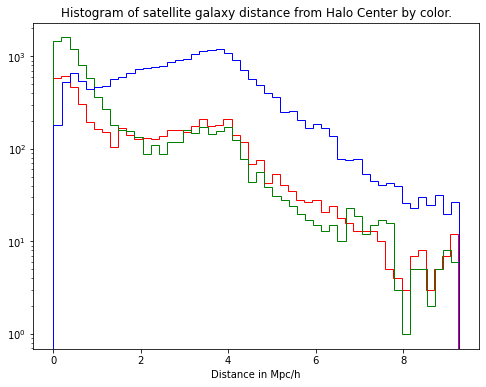

In [16]:
arrs = [satellites_red, satellites_green, satellites_blue]
color = ['red', 'green', 'blue']
plt.figure(figsize=(8,6))
for i in range(0,3):
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = arrs[i]['SubhaloPos']-arrs[i]['GroupPos']

    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    print(r_subhalo.shape)
    mass = np.array(np.log10(arrs[i]["StellarMass"]*1e10))
    plt.hist(r_subhalo, bins=50, color=color[i], histtype='step', log='True')# , density=True), ('label1', 'label2', 'label3'))
    print("Mean distance of " + color[i] + " galaxies from halo center in Mpc/h: " + str(np.mean(r_subhalo)))
    print("Number of subhalos that are " + color[i] + ": " +str(len(r_subhalo)) + "\n")
    
plt.title("Histogram of satellite galaxy distance from Halo Center by color.")
plt.xlabel("Distance in Mpc/h")
plt.show()

9074
(9074,)


Text(0.5, 1.0, 'Mean dist of red2 galaxies from Illustris halo center in Mpc/h: 0.40668198')

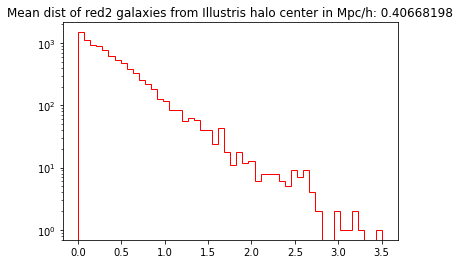

In [18]:
boxsize = header['BoxSize'] #kpc/h
box_bounds = boxsize*np.ones(3)#*conv_fac
sgreen = cut_mass_low(cut_color_lines(og_sats_green, 0.55, 1000), "StellarMass" ,10.2)
print(len(sgreen))
dev = sgreen['SubhaloPos']-sgreen['GroupPos']

for ind, q in enumerate(dev.T):
    q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
    dev.T[ind] = q
r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
print(r_subhalo.shape)
mass = np.array(np.log10(sgreen["StellarMass"]*1e10))
plt.hist(r_subhalo, bins=50, color='red', histtype='step', log='True')# , density=True), ('label1', 'label2', 'label3'))
plt.title("Mean dist of red2 galaxies from Illustris halo center in Mpc/h: " + str(np.mean(r_subhalo)))

Text(0.5, 1.0, 'Host Halo Masses of red2 galaxies')

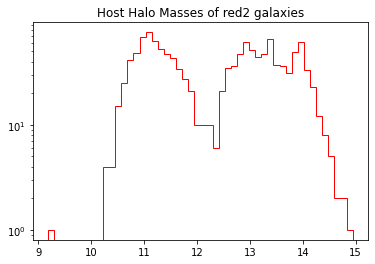

In [22]:
mass = np.array(np.log10(sgreen['GroupMass']*1e10))
mass = set(mass)
plt.hist(mass, bins=50, color='red', histtype='step', log='True')# , density=True), ('label1', 'label2', 'label3'))
plt.title("Host Halo Masses of red2 galaxies")

### Run Phase Space Binned

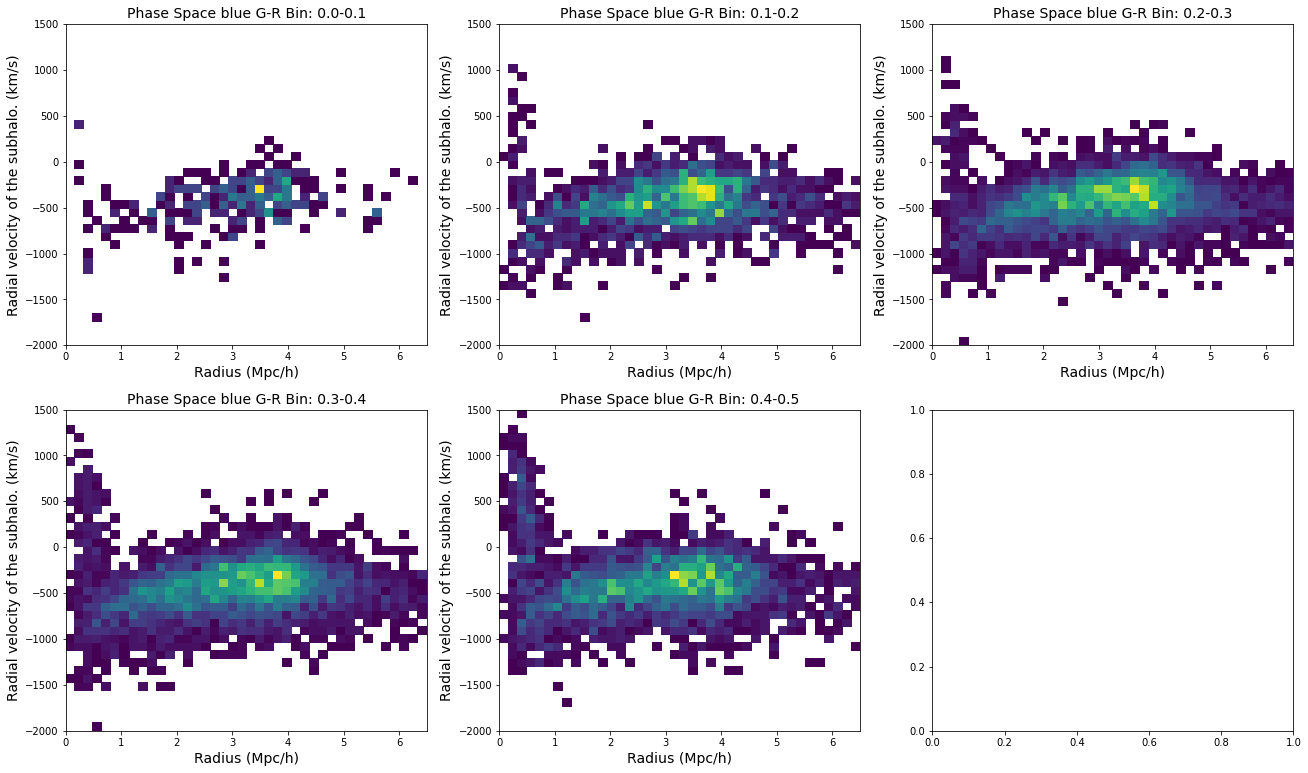

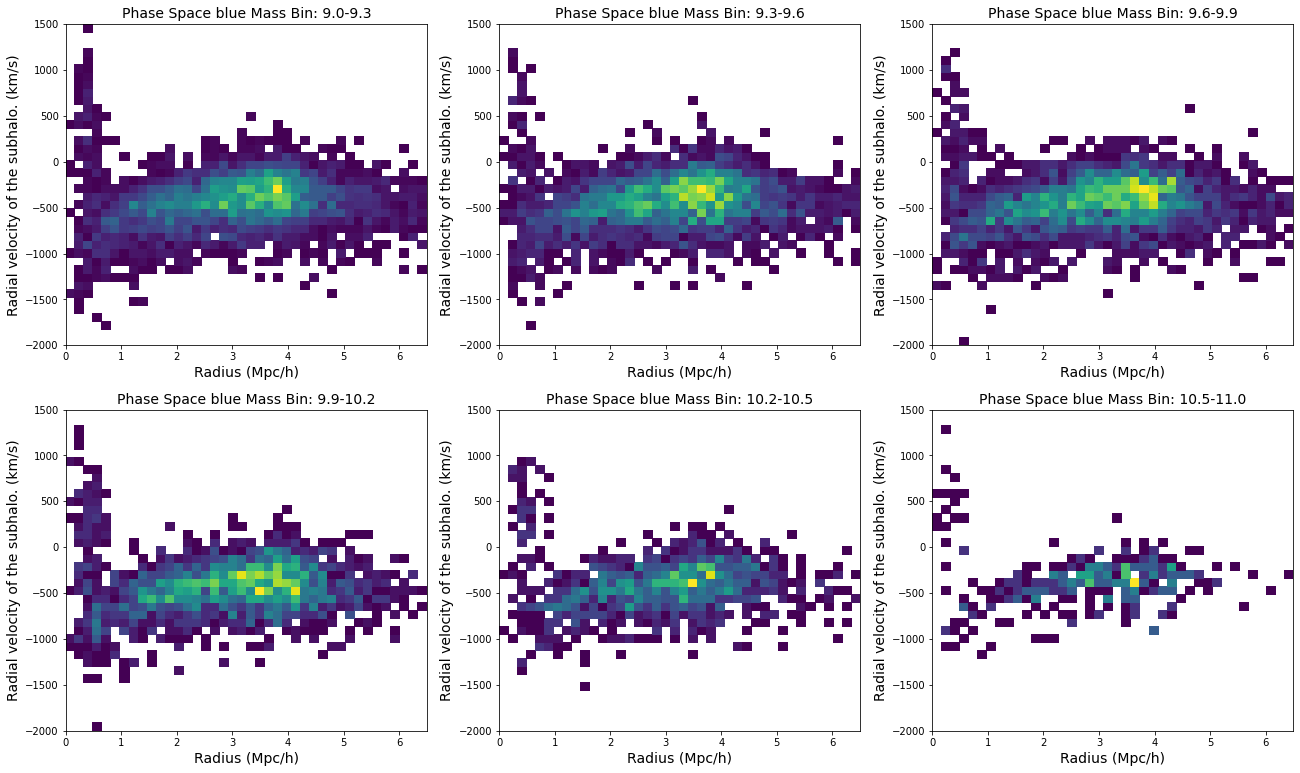

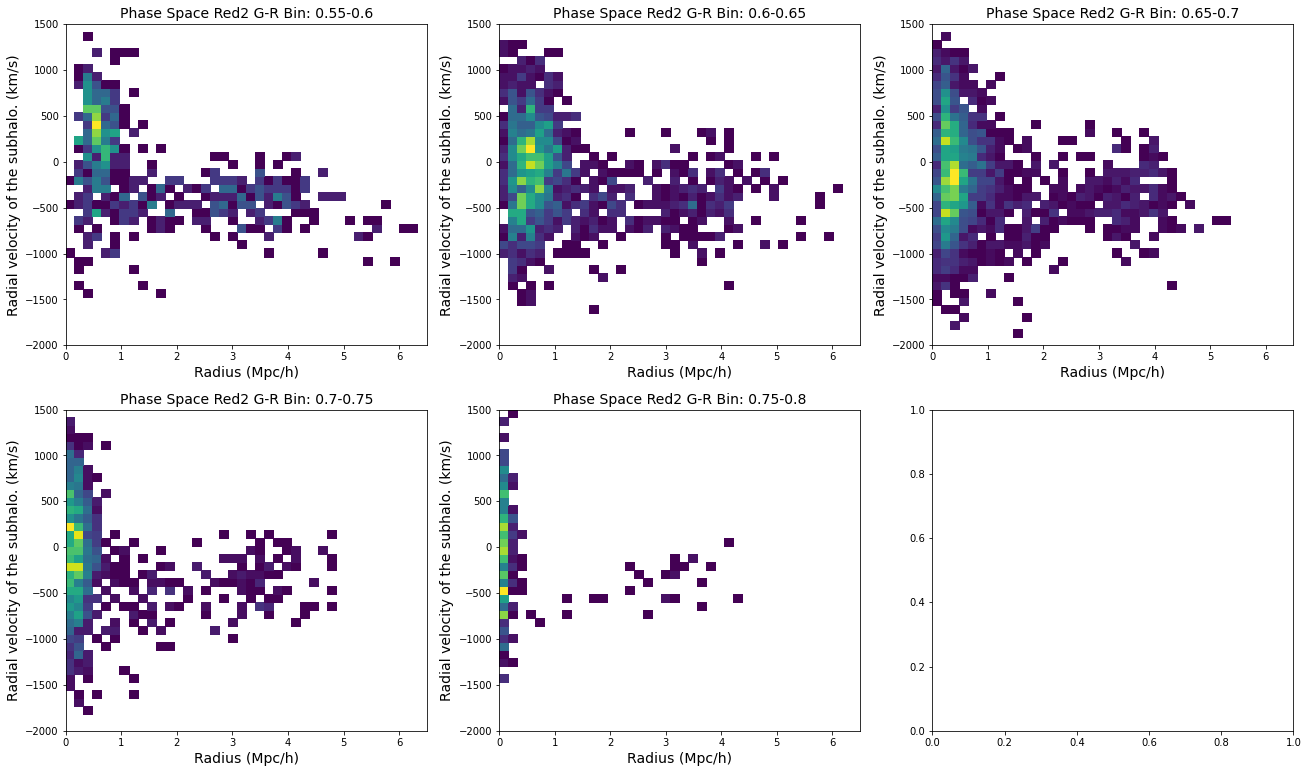

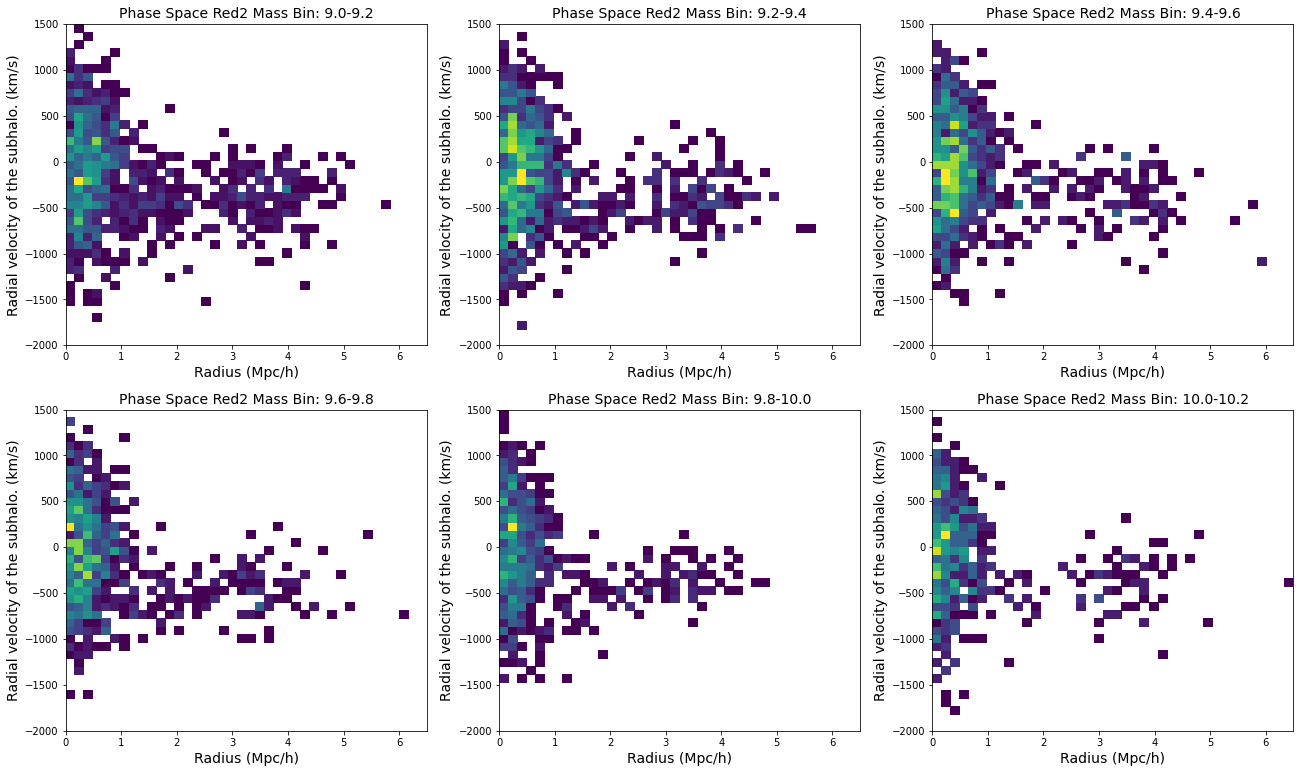

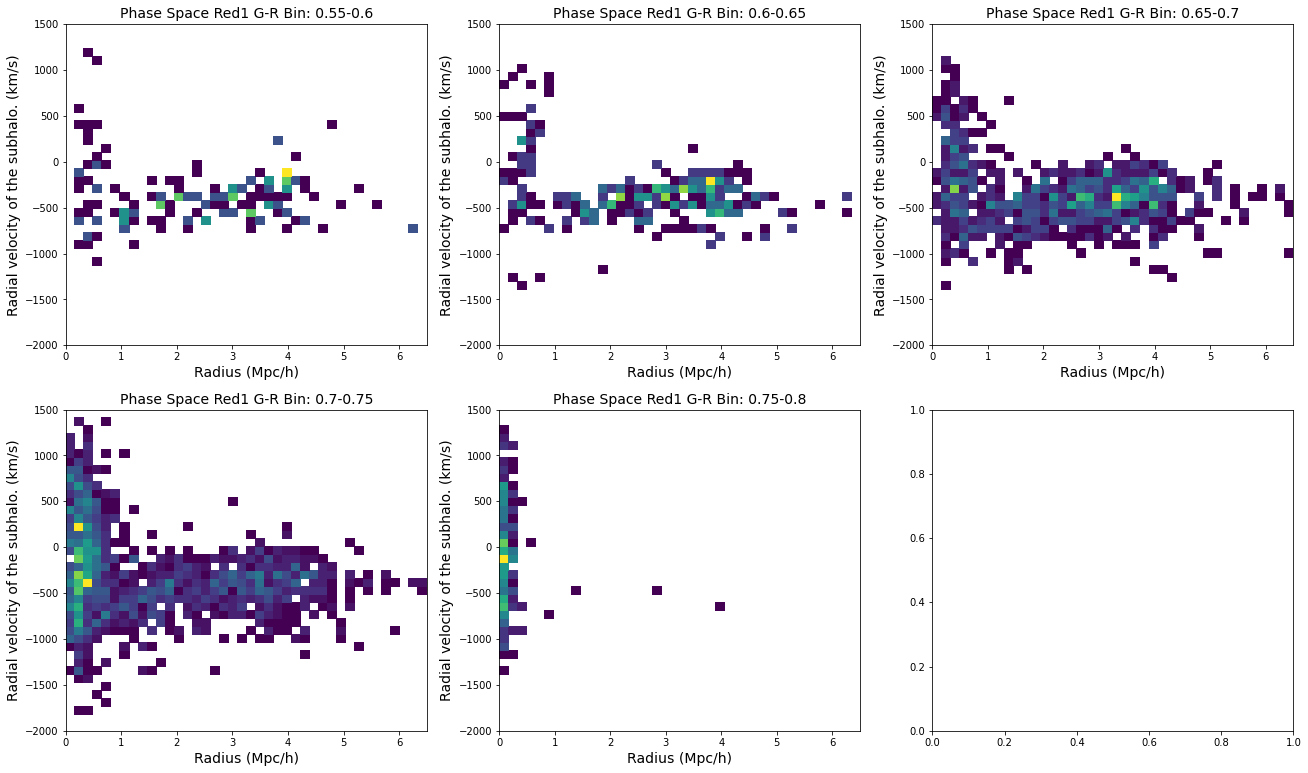

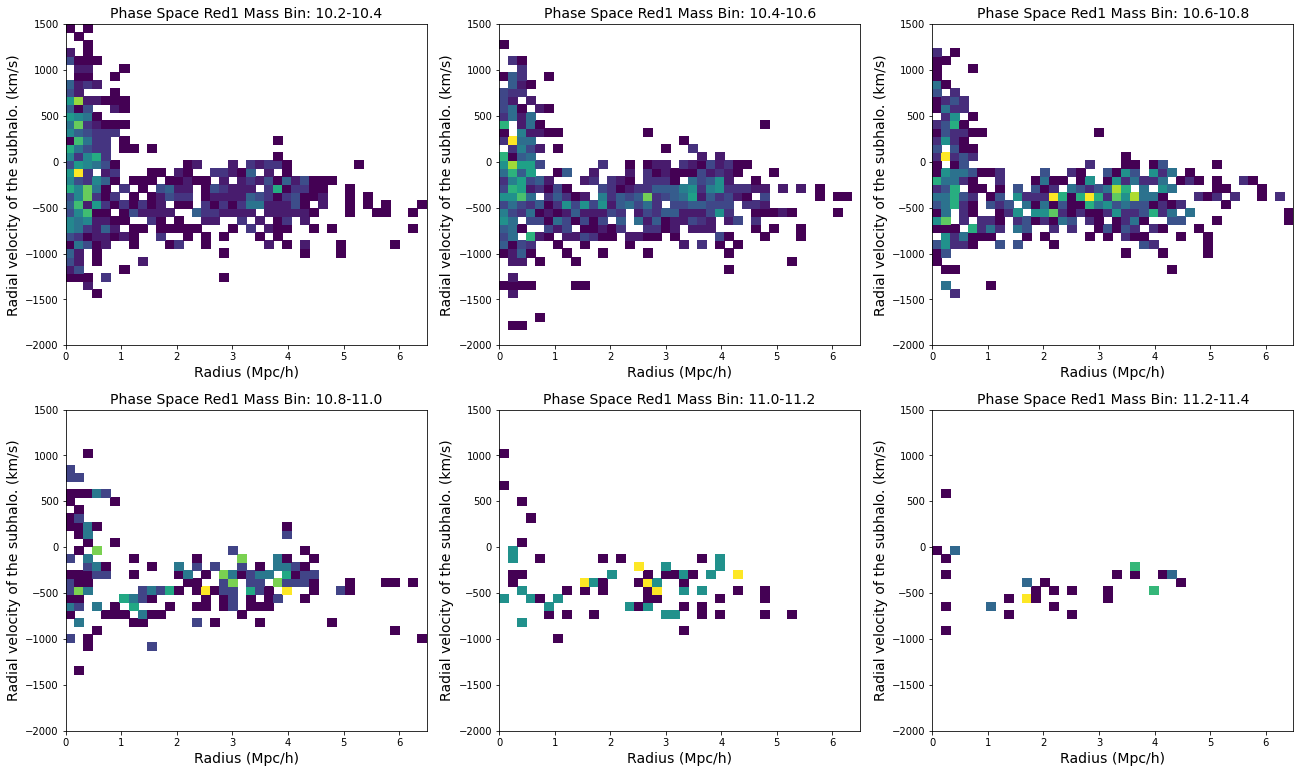

In [24]:
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
phase_space_color_bins(satellites_blue, "blue", "StellarMass", bins)
bins = [9.0,9.3,9.6,9.9,10.2,10.5,11.0]
phase_space_mass_bins(satellites_blue, "blue", "StellarMass", bins)
bins = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
phase_space_color_bins(satellites_green, "Red2", "StellarMass", bins)
bins = [9.0,9.2,9.4,9.6,9.8,10.0,10.2]
phase_space_mass_bins(satellites_green, "Red2", "StellarMass", bins)
bins = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
phase_space_color_bins(satellites_red, "Red1", "StellarMass", bins)
bins = [10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4]
phase_space_mass_bins(satellites_red, "Red1", "StellarMass", bins)

### Other Phase Space

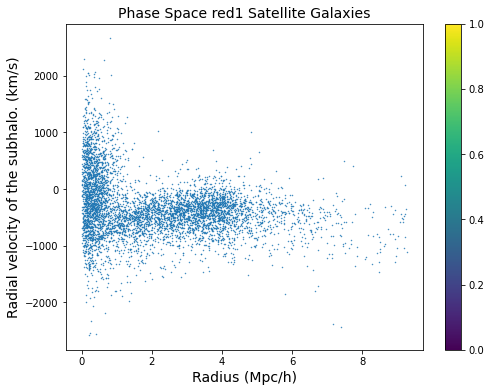

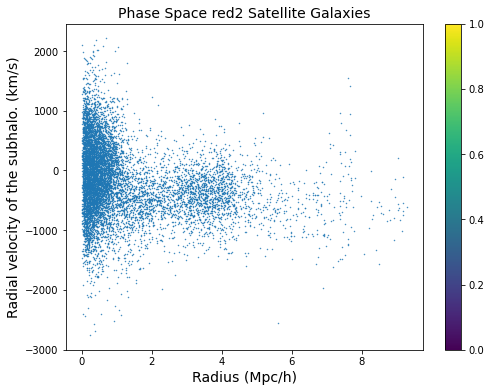

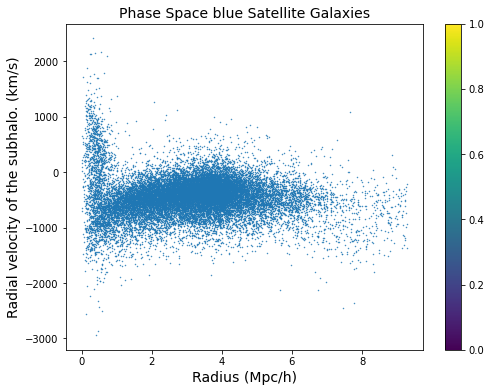

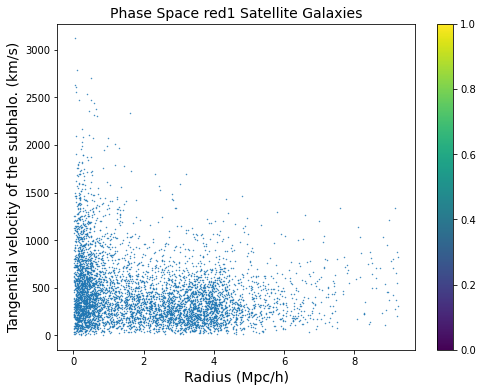

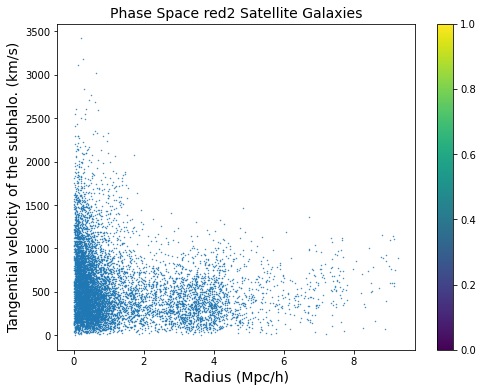

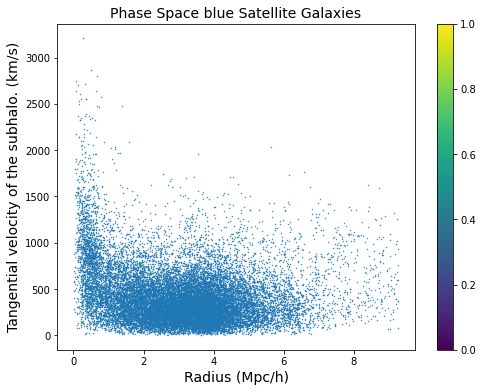

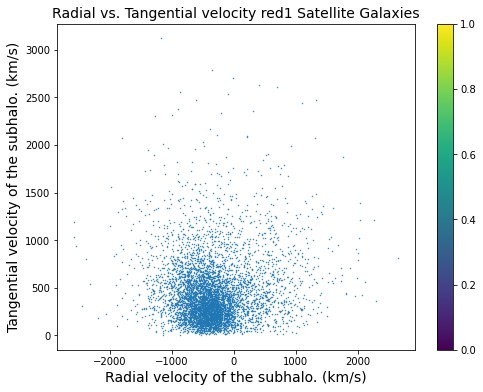

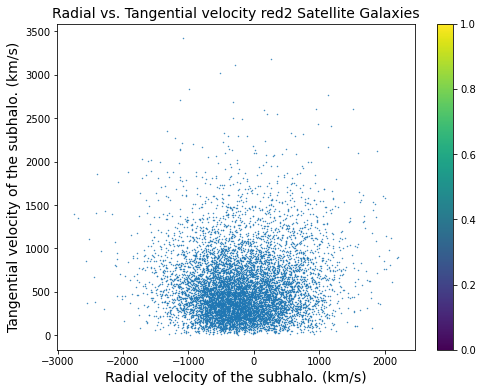

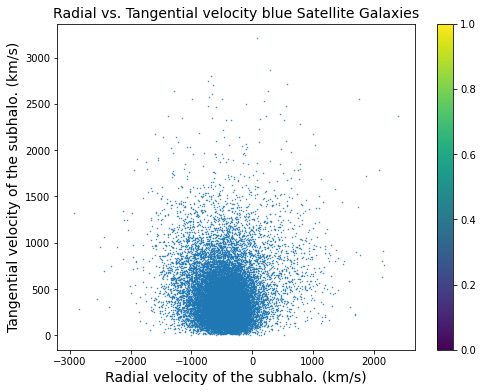

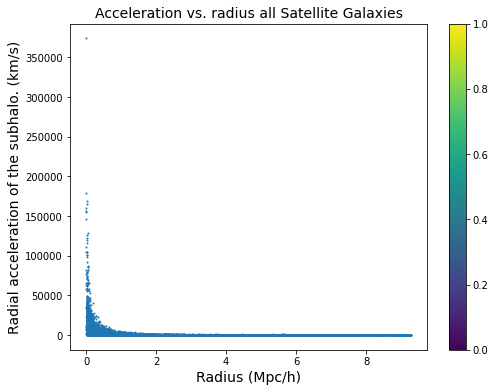

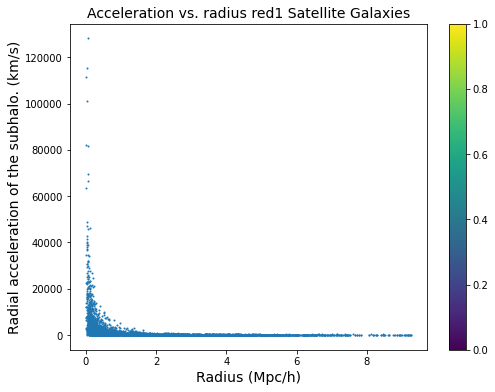

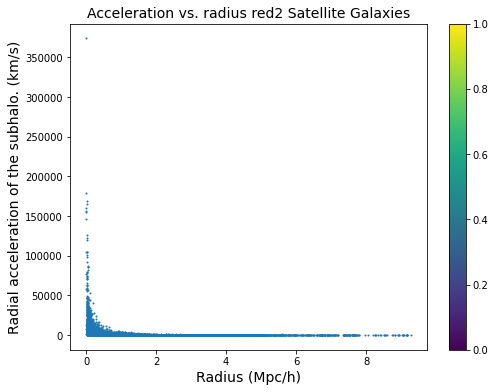

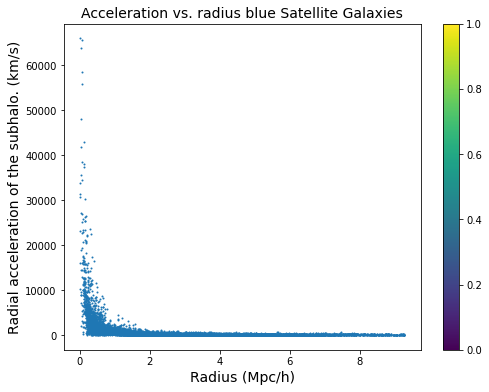

In [25]:
phase_space(satellites_red, "Satellite Galaxies", "red1", "StellarMass")
phase_space(satellites_green, "Satellite Galaxies", "red2", "StellarMass")
phase_space(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")
tangential_v1(satellites_red, "Satellite Galaxies", "red1", "StellarMass")
tangential_v1(satellites_green, "Satellite Galaxies", "red2", "StellarMass")
tangential_v1(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")
tangential_v_radial(satellites_red, "Satellite Galaxies", "red1", "StellarMass")
tangential_v_radial(satellites_green, "Satellite Galaxies", "red2", "StellarMass")
tangential_v_radial(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")
cent_acc_vs_rad(satellites, "Satellite Galaxies", "all", "StellarMass")
cent_acc_vs_rad(satellites_red, "Satellite Galaxies", "red1", "StellarMass")
cent_acc_vs_rad(satellites_green, "Satellite Galaxies", "red2", "StellarMass")
cent_acc_vs_rad(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")